In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [2]:
data =pd.read_csv("avocado.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [4]:
data.head()

Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0           0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1           1  2015-12-20          1.35      54876.98   674.28   44638.81   
2           2  2015-12-13          0.93     118220.22   794.70  109149.67   
3           3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4           4  2015-11-29          1.28      51039.60   941.48   43838.39   

     4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0   48.16     8696.87     8603.62       93.25          0.0  conventional   
1   58.33     9505.56     9408.07       97.49          0.0  conventional   
2  130.50     8145.35     8042.21      103.14          0.0  conventional   
3   72.58     5811.16     5677.40      133.76          0.0  conventional   
4   75.78     6183.95     5986.26      197.69          0.0  conventional   

   year  region  
0  2015  Albany  
1  2015  Albany  
2  2015  Albany  
3  2015  Albany  
4  2015  Albany

In [5]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [6]:
data.head(2)

Date  AveragePrice  Total Volume     4046      4225   4770  \
0  2015-12-27          1.33      64236.62  1036.74  54454.85  48.16   
1  2015-12-20          1.35      54876.98   674.28  44638.81  58.33   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  region  
0     8696.87     8603.62       93.25          0.0  conventional  2015  Albany  
1     9505.56     9408.07       97.49          0.0  conventional  2015  Albany

Request 1: Organic Avocados' Price Prediction
Lineear Regression, Random Forest, XGB Regressor...- Regression Algorithm

Buoc 3: Data preparation

In [7]:
df = data.copy(deep=True)

First EDA =>Check data

In [8]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From Pandas Profilling Report we see that:
    + No missing cells
    + No duplicate rows

In [9]:
# we can check again
df.isnull().any()

Date            False
AveragePrice    False
Total Volume    False
4046            False
4225            False
4770            False
Total Bags      False
Small Bags      False
Large Bags      False
XLarge Bags     False
type            False
year            False
region          False
dtype: bool

In [10]:
df.isna().any()

Date            False
AveragePrice    False
Total Volume    False
4046            False
4225            False
4770            False
Total Bags      False
Small Bags      False
Large Bags      False
XLarge Bags     False
type            False
year            False
region          False
dtype: bool

In [11]:
df.duplicated().any()

False

In [12]:
df.shape

(18249, 13)

Wheter the Categorical Features('type'/'region') affected the 'AveragePrice'?

Whheter the Categorical Features('type') affected the 'AveragePrice'?

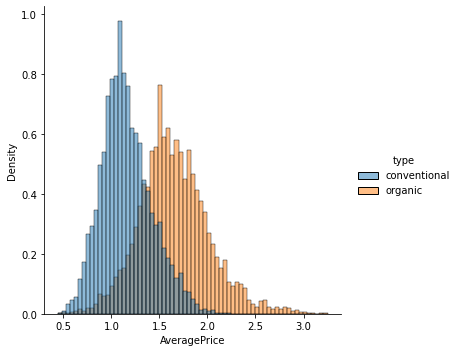

In [13]:
#AveragePrice Distribution/ Boxplot of 2 types of Avocados
sns.displot(df, x="AveragePrice",hue="type", stat="density")
plt.show()

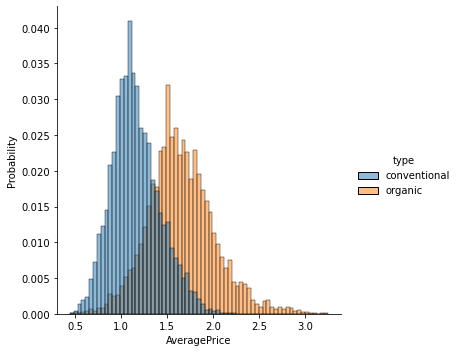

In [14]:
sns.displot(df, x="AveragePrice",hue="type", stat="probability")
plt.show()

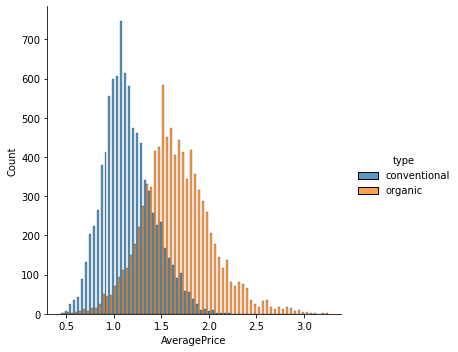

In [15]:
sns.displot(df, x="AveragePrice",hue="type", multiple="dodge")
plt.show()

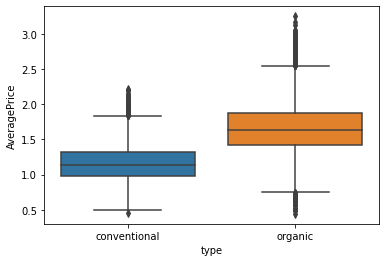

In [16]:
sns.boxplot(data=df, x="type", y="AveragePrice")
plt.show()

Organic Avocado is more expansive than conventional avocado.
"AveragePrice" was affected by "type"

Whether the "region" affected 'AveragePrice' ?

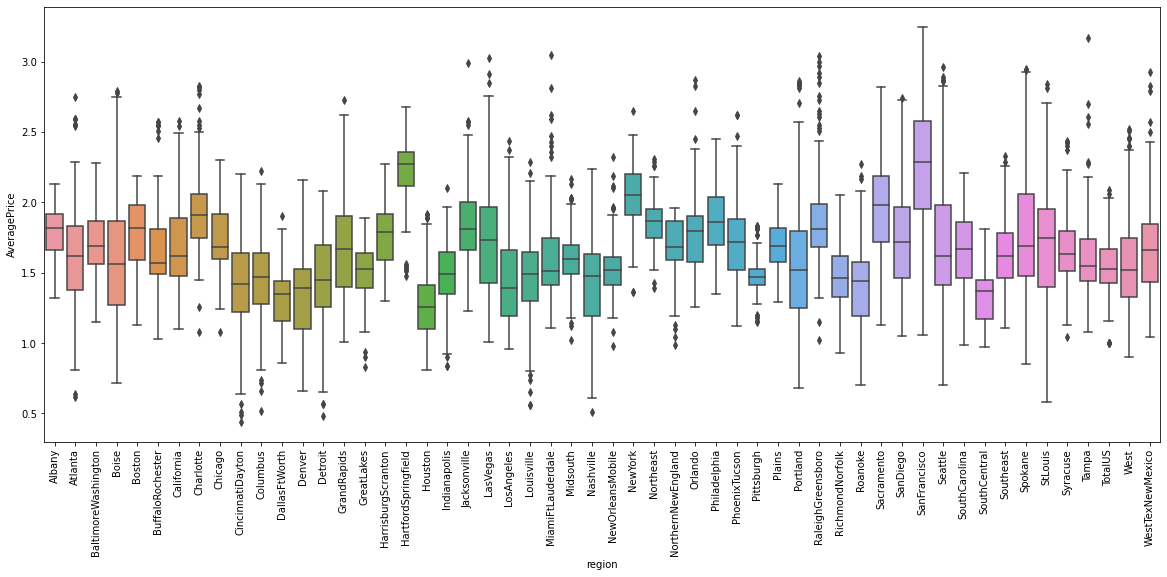

In [17]:
# type == "organic"
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data = df[df['type']=='organic'],
           x="region", y="AveragePrice", ax=ax)
plt.xticks(rotation=90)
plt.show()

Some region have high price
Some region have low price

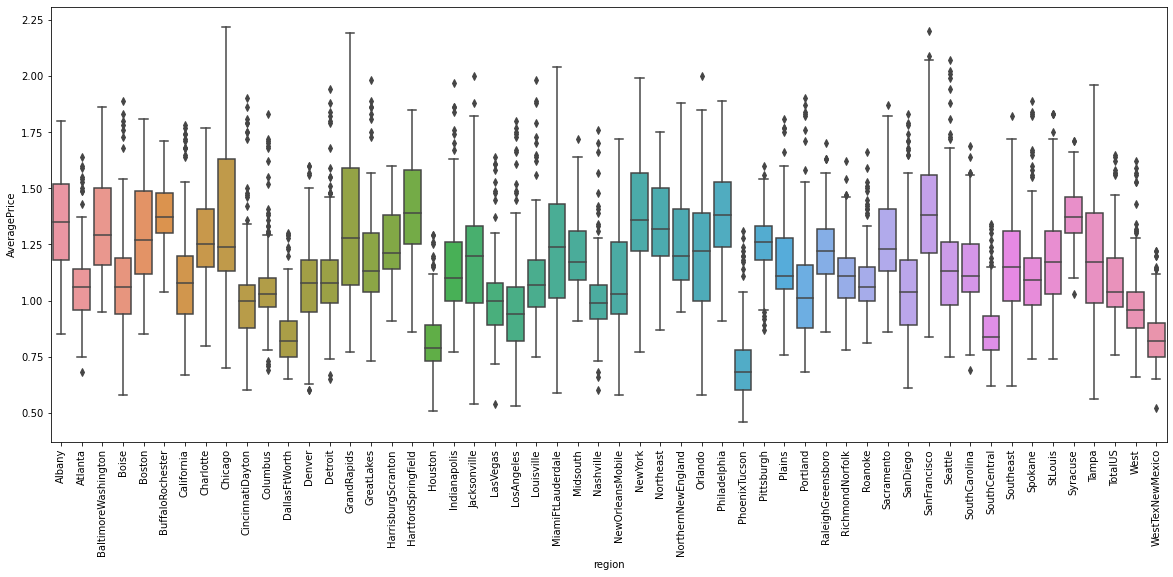

In [18]:
# type == 'conventional'
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data = df[df['type']=='conventional'],
           x="region", y="AveragePrice", ax=ax)
plt.xticks(rotation=90)
plt.show()

Some region have high price
Some region have low price

Whether the Continuous Features affected the "AveragePrice"

In [19]:
#Correlation
corr = df.corr()
corr

AveragePrice  Total Volume      4046      4225      4770  \
AveragePrice      1.000000     -0.192752 -0.208317 -0.172928 -0.179446   
Total Volume     -0.192752      1.000000  0.977863  0.974181  0.872202   
4046             -0.208317      0.977863  1.000000  0.926110  0.833389   
4225             -0.172928      0.974181  0.926110  1.000000  0.887855   
4770             -0.179446      0.872202  0.833389  0.887855  1.000000   
Total Bags       -0.177088      0.963047  0.920057  0.905787  0.792314   
Small Bags       -0.174730      0.967238  0.925280  0.916031  0.802733   
Large Bags       -0.172940      0.880640  0.838645  0.810015  0.698471   
XLarge Bags      -0.117592      0.747157  0.699377  0.688809  0.679861   
year              0.093197      0.017193  0.003353 -0.009559 -0.036531   

              Total Bags  Small Bags  Large Bags  XLarge Bags      year  
AveragePrice   -0.177088   -0.174730   -0.172940    -0.117592  0.093197  
Total Volume    0.963047    0.967238    0.880640     0.747157  0.017193  
4046            0.920057    0.925280    0.838645     0.699377  0.003353  
4225            0.905787    0.916031    0.810015     0.688809 -0.009559  
4770            0.792314    0.802733    0.698471     0.679861 -0.036531  
Total Bags      1.000000    0.994335    0.943009     0.804233  0.071552  
Small Bags      0.994335    1.000000    0.902589     0.806845  0.063915  
Large Bags      0.943009    0.902589    1.000000     0.710858  0.087891  
XLarge Bags     0.804233    0.806845    0.710858     1.000000  0.081033  
year            0.071552    0.063915    0.087891     0.081033  1.000000

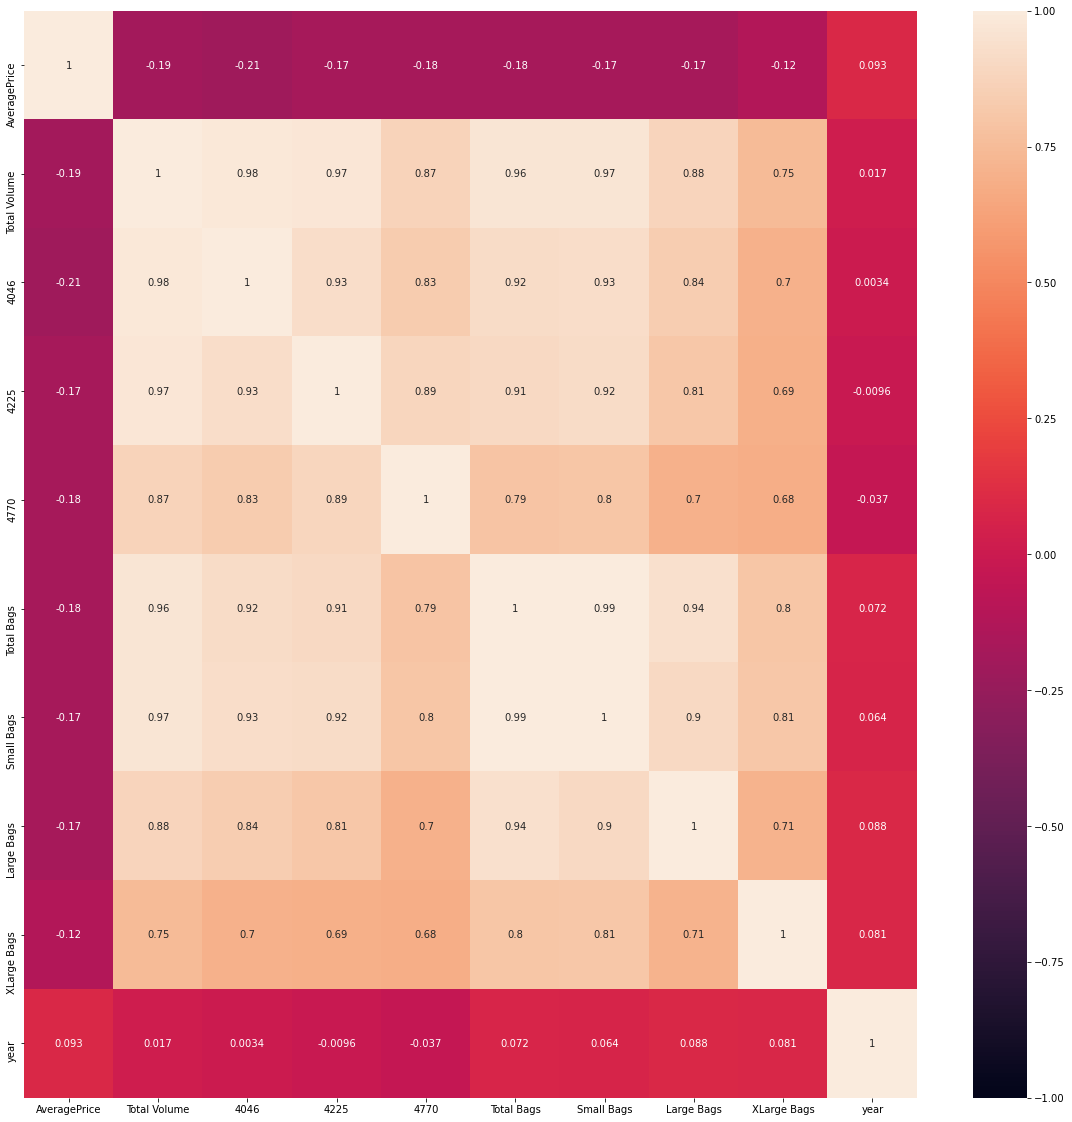

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.show()

Corr between AveragePrice with other factor is very low 
other factor don't affect to AveragePrice

Feature Engineering
+ About Date, we can now the season in USA from https://seasonsyear.com/USA
    + US'Spring  months are March, April and May (3,4,5)
    + US'summer  months are june, July and August (6,7,8)
    + US'autumn  months are Sep, Oct and Nov (9,10,11)    
    + US'winter  months are Dec, jan and Feb (12,1,2)

In [21]:
def convert_moth(month):
    if month == 3 or month == 4 or month == 5:
        return 0
    elif month == 6 or month == 7 or month == 8:
        return 1    
    if month == 9 or month == 10 or month == 11:
        return 2
    else:
        return 3

In [22]:
df['Date'] = pd.to_datetime(df["Date"])

In [23]:
df['Month'] = pd.DatetimeIndex(df["Date"]).month

In [24]:
df['Season'] = df["Month"].apply(lambda x: convert_moth(x))

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
 13  Month         18249 non-null  int64         
 14  Season        18249 non-null  int64         
dtypes: datetime64[ns](1), float64(9), in

In [26]:
df.head()

Date  AveragePrice  Total Volume     4046       4225    4770  \
0 2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1 2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2 2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3 2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4 2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0     8696.87     8603.62       93.25          0.0  conventional  2015   
1     9505.56     9408.07       97.49          0.0  conventional  2015   
2     8145.35     8042.21      103.14          0.0  conventional  2015   
3     5811.16     5677.40      133.76          0.0  conventional  2015   
4     6183.95     5986.26      197.69          0.0  conventional  2015   

   region  Month  Season  
0  Albany     12       3  
1  Albany     12       3  
2  Albany     12       3  
3  Albany     12       3  
4  Albany     11       2

Whether "Season" affect AveragePrice ?

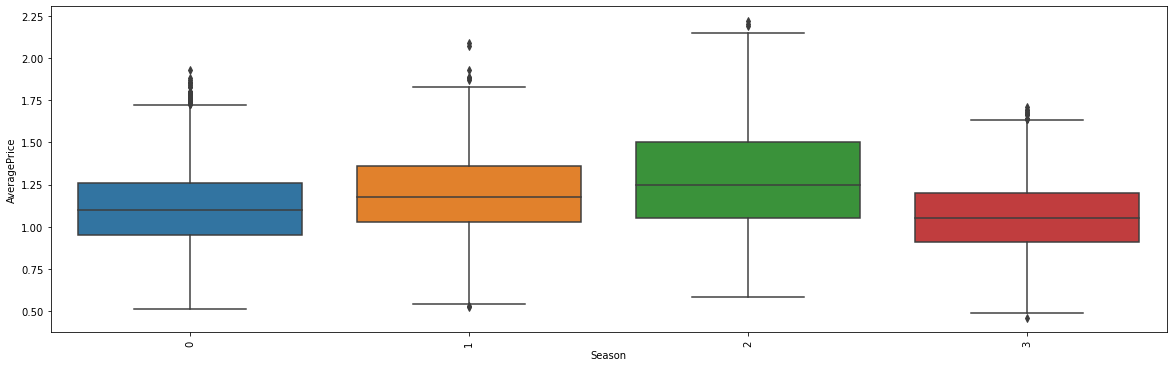

In [27]:
#type = conventional
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(data = df[df['type']=='conventional'],
           x="Season", y="AveragePrice", ax=ax)
plt.xticks(rotation=90)
plt.show()

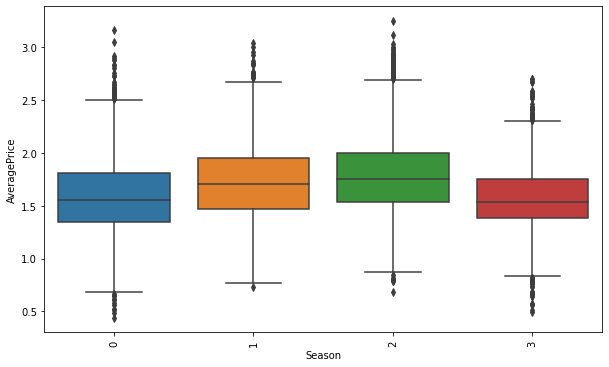

In [28]:
#type = Organic
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data = df[df['type']=='organic'],
           x="Season", y="AveragePrice", ax=ax)
plt.xticks(rotation=90)
plt.show()

Yes, AveragePrice was affected by "Season" (both in 'Organic' type and "conventional" type)

In [29]:
# Label Encoder and OnehotEncoder for 'type' and 'region'
le = LabelEncoder()
df['type_new'] = le.fit_transform(df['type'])

In [30]:
df.head()

Date  AveragePrice  Total Volume     4046       4225    4770  \
0 2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1 2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2 2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3 2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4 2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0     8696.87     8603.62       93.25          0.0  conventional  2015   
1     9505.56     9408.07       97.49          0.0  conventional  2015   
2     8145.35     8042.21      103.14          0.0  conventional  2015   
3     5811.16     5677.40      133.76          0.0  conventional  2015   
4     6183.95     5986.26      197.69          0.0  conventional  2015   

   region  Month  Season  type_new  
0  Albany     12       3         0  
1  Albany     12       3         0  
2  Albany     12       3         0  
3  Albany     12       3         0  
4  Albany     11       2         0

In [31]:
df_ohe = pd.get_dummies(data=df, columns=["region"])
df_ohe.head()

Date  AveragePrice  Total Volume     4046       4225    4770  \
0 2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1 2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2 2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3 2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4 2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags  ... region_SouthCarolina  \
0     8696.87     8603.62       93.25          0.0  ...                    0   
1     9505.56     9408.07       97.49          0.0  ...                    0   
2     8145.35     8042.21      103.14          0.0  ...                    0   
3     5811.16     5677.40      133.76          0.0  ...                    0   
4     6183.95     5986.26      197.69          0.0  ...                    0   

   region_SouthCentral  region_Southeast  region_Spokane  region_StLouis  \
0                    0                 0               0               0   
1                    0                 0               0               0   
2                    0                 0               0               0   
3                    0                 0               0               0   
4                    0                 0               0               0   

   region_Syracuse  region_Tampa  region_TotalUS  region_West  \
0                0             0               0            0   
1                0             0               0            0   
2                0             0               0            0   
3                0             0               0            0   
4                0             0               0            0   

   region_WestTexNewMexico  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 69 columns]

In [32]:
df_ohe.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'Month', 'Season', 'type_new', 'region_Albany', 'region_Atlanta',
       'region_BaltimoreWashington', 'region_Boise', 'region_Boston',
       'region_BuffaloRochester', 'region_California', 'region_Charlotte',
       'region_Chicago', 'region_CincinnatiDayton', 'region_Columbus',
       'region_DallasFtWorth', 'region_Denver', 'region_Detroit',
       'region_GrandRapids', 'region_GreatLakes', 'region_HarrisburgScranton',
       'region_HartfordSpringfield', 'region_Houston', 'region_Indianapolis',
       'region_Jacksonville', 'region_LasVegas', 'region_LosAngeles',
       'region_Louisville', 'region_MiamiFtLauderdale', 'region_Midsouth',
       'region_Nashville', 'region_NewOrleansMobile', 'region_NewYork',
       'region_Northeast', 'region_NorthernNewEngland', 'region_Orlando',
       'region_Philadelphia', 'region_PhoenixT

In [33]:
# Choose TotalVolumebc it has high corr with '4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags'
X = df_ohe.drop(['Date', "AveragePrice",'type', '4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags'], axis=1)
y = df['AveragePrice']

In [34]:
X.head()

Total Volume  Total Bags  year  Month  Season  type_new  region_Albany  \
0      64236.62     8696.87  2015     12       3         0              1   
1      54876.98     9505.56  2015     12       3         0              1   
2     118220.22     8145.35  2015     12       3         0              1   
3      78992.15     5811.16  2015     12       3         0              1   
4      51039.60     6183.95  2015     11       2         0              1   

   region_Atlanta  region_BaltimoreWashington  region_Boise  ...  \
0               0                           0             0  ...   
1               0                           0             0  ...   
2               0                           0             0  ...   
3               0                           0             0  ...   
4               0                           0             0  ...   

   region_SouthCarolina  region_SouthCentral  region_Southeast  \
0                     0                    0                 0   
1                     0                    0                 0   
2                     0                    0                 0   
3                     0                    0                 0   
4                     0                    0                 0   

   region_Spokane  region_StLouis  region_Syracuse  region_Tampa  \
0               0               0                0             0   
1               0               0                0             0   
2               0               0                0             0   
3               0               0                0             0   
4               0               0                0             0   

   region_TotalUS  region_West  region_WestTexNewMexico  
0               0            0                        0  
1               0            0                        0  
2               0            0                        0  
3               0            0                        0  
4               0            0                        0  

[5 rows x 60 columns]

Buoc 4&5: Modeling & Evaluation/Analyze & Report

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [36]:
# Have many range values => Scaler (and large samples ~ 18k) => StandardScaler

In [37]:
pipe_LR = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe_LR.fit(X_train, y_train)
y_pred_LR = pipe_LR.predict(X_test)
r2_score(y_test, y_pred_LR)

0.5819622411510237

In [38]:
mae_LR = mean_absolute_error(y_test, y_pred_LR)
mae_LR

0.1967517994806079

In [39]:
pipe_RF = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
pipe_RF.fit(X_train, y_train)
y_pred_RF = pipe_LR.predict(X_test)
r2_score(y_test, y_pred_LR)

0.5819622411510237

In [40]:
mae_RF = mean_absolute_error(y_test, y_pred_RF)
mae_RF

0.1967517994806079

In [41]:
pipe_XGB = Pipeline([('scaler', StandardScaler()), ('xgb', XGBRegressor())])
pipe_XGB.fit(X_train, y_train)
y_pred_XGB = pipe_XGB.predict(X_test)
r2_score(y_test, y_pred_XGB)

0.8905047345394455

In [42]:
mae_XGB = mean_absolute_error(y_test, y_pred_XGB)
mae_XGB

0.0947918049729578

Select RandomForestRegressor bc it has highest r^2 and lowest MAE

In [43]:
pd.DataFrame(pipe_RF['rf'].feature_importances_,
            index=X_train.columns,
            columns=['feature_importances']).sort_values(by=['feature_importances'],
                                                       ascending=False)

feature_importances
type_new                               0.381853
Total Bags                             0.113174
Total Volume                           0.083690
year                                   0.072369
Month                                  0.068818
Season                                 0.030231
region_HartfordSpringfield             0.024654
region_NewYork                         0.021373
region_SanFrancisco                    0.019096
region_Northeast                       0.012786
region_Philadelphia                    0.009254
region_BaltimoreWashington             0.008405
region_RaleighGreensboro               0.007316
region_BuffaloRochester                0.006536
region_Seattle                         0.005929
region_Louisville                      0.005719
region_PhoenixTucson                   0.005606
region_Portland                        0.005414
region_HarrisburgScranton              0.005405
region_Boston                          0.005176
region_Houston                         0.005161
region_Nashville                       0.005030
region_Boise                           0.004865
region_CincinnatiDayton                0.004167
region_Chicago                         0.003953
region_GrandRapids                     0.003898
region_WestTexNewMexico                0.003817
region_NorthernNewEngland              0.003613
region_SouthCentral                    0.003600
region_Columbus                        0.003501
region_Charlotte                       0.003495
region_Plains                          0.003402
region_Spokane                         0.002903
region_California                      0.002901
region_Denver                          0.002873
region_LasVegas                        0.002807
region_Roanoke                         0.002777
region_Syracuse                        0.002742
region_DallasFtWorth                   0.002719
region_Detroit                         0.002611
region_Pittsburgh                      0.002604
region_MiamiFtLauderdale               0.002528
region_Atlanta                         0.002524
region_LosAngeles                      0.002459
region_StLouis                         0.002430
region_Indianapolis                    0.002320
region_West                            0.002271
region_SanDiego                        0.002111
region_Southeast                       0.001924
region_Midsouth                        0.001908
region_Orlando                         0.001677
region_NewOrleansMobile                0.001646
region_Sacramento                      0.001625
region_Jacksonville                    0.001581
region_Tampa                           0.001557
region_RichmondNorfolk                 0.001532
region_Albany                          0.001296
region_SouthCarolina                   0.001047
region_GreatLakes                      0.000904
region_TotalUS                         0.000418

In [44]:
pd.DataFrame(pipe_RF['rf'].feature_importances_, \
             index=X_train.columns, \
             columns=['feature_importances']).sort_values(by=['feature_importances'], \
                                                           ascending=False)

feature_importances
type_new                               0.381853
Total Bags                             0.113174
Total Volume                           0.083690
year                                   0.072369
Month                                  0.068818
Season                                 0.030231
region_HartfordSpringfield             0.024654
region_NewYork                         0.021373
region_SanFrancisco                    0.019096
region_Northeast                       0.012786
region_Philadelphia                    0.009254
region_BaltimoreWashington             0.008405
region_RaleighGreensboro               0.007316
region_BuffaloRochester                0.006536
region_Seattle                         0.005929
region_Louisville                      0.005719
region_PhoenixTucson                   0.005606
region_Portland                        0.005414
region_HarrisburgScranton              0.005405
region_Boston                          0.005176
region_Houston                         0.005161
region_Nashville                       0.005030
region_Boise                           0.004865
region_CincinnatiDayton                0.004167
region_Chicago                         0.003953
region_GrandRapids                     0.003898
region_WestTexNewMexico                0.003817
region_NorthernNewEngland              0.003613
region_SouthCentral                    0.003600
region_Columbus                        0.003501
region_Charlotte                       0.003495
region_Plains                          0.003402
region_Spokane                         0.002903
region_California                      0.002901
region_Denver                          0.002873
region_LasVegas                        0.002807
region_Roanoke                         0.002777
region_Syracuse                        0.002742
region_DallasFtWorth                   0.002719
region_Detroit                         0.002611
region_Pittsburgh                      0.002604
region_MiamiFtLauderdale               0.002528
region_Atlanta                         0.002524
region_LosAngeles                      0.002459
region_StLouis                         0.002430
region_Indianapolis                    0.002320
region_West                            0.002271
region_SanDiego                        0.002111
region_Southeast                       0.001924
region_Midsouth                        0.001908
region_Orlando                         0.001677
region_NewOrleansMobile                0.001646
region_Sacramento                      0.001625
region_Jacksonville                    0.001581
region_Tampa                           0.001557
region_RichmondNorfolk                 0.001532
region_Albany                          0.001296
region_SouthCarolina                   0.001047
region_GreatLakes                      0.000904
region_TotalUS                         0.000418

Request 2: Organic Avocado Average Price Prediction for the future in California ARIMA & PROPHET - Time Series Algorrithm (0.5) 

In [45]:
# Make new dataframe from orginal dataframe: data
df_ca = data[data['region'] == 'California']
df_ca['Date'] = df_ca['Date'].str[:-3]
df_ca = df_ca[data['type'] == 'organic']

<ipython-input-45-fba24ff0beb6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['Date'] = df_ca['Date'].str[:-3]
<ipython-input-45-fba24ff0beb6>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ca = df_ca[data['type'] == 'organic']


In [46]:
df_ca.shape

(169, 13)

In [47]:
agg = {'AveragePrice': 'mean'}
df_ca_gr = df_ca.groupby(df_ca['Date']).aggregate(agg).reset_index()
df_ca_gr.head()

Date  AveragePrice
0  2015-01        1.2200
1  2015-02        1.3475
2  2015-03        1.3960
3  2015-04        1.5100
4  2015-05        1.4740

In [48]:
df_ts = pd.DataFrame()
df_ts['ds'] = pd.to_datetime(df_ca_gr['Date'])
df_ts['y'] = df_ca_gr['AveragePrice']
df_ts.head()

ds       y
0 2015-01-01  1.2200
1 2015-02-01  1.3475
2 2015-03-01  1.3960
3 2015-04-01  1.5100
4 2015-05-01  1.4740

In [49]:
df_ts.tail()

ds       y
34 2017-11-01  1.9325
35 2017-12-01  1.7960
36 2018-01-01  1.7800
37 2018-02-01  1.8000
38 2018-03-01  1.6500

In [50]:
df_ts.shape

(39, 2)

In [51]:
# Mean of Organic Avocado AveragePrice in California
df_ts['y'].mean()

1.6847820512820515

Use df_ts1 for ARIMA, df_ts for Prophet

In [52]:
df_ts1 = df_ts.copy(deep=False)

In [53]:
df_ts1.index = pd.to_datetime(df_ts1.ds)

In [54]:
df_ts1.index

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [55]:
df_ts1.head()

ds       y
ds                           
2015-01-01 2015-01-01  1.2200
2015-02-01 2015-02-01  1.3475
2015-03-01 2015-03-01  1.3960
2015-04-01 2015-04-01  1.5100
2015-05-01 2015-05-01  1.4740

In [56]:
df_ts1 = df_ts1.drop(['ds'], axis=1)

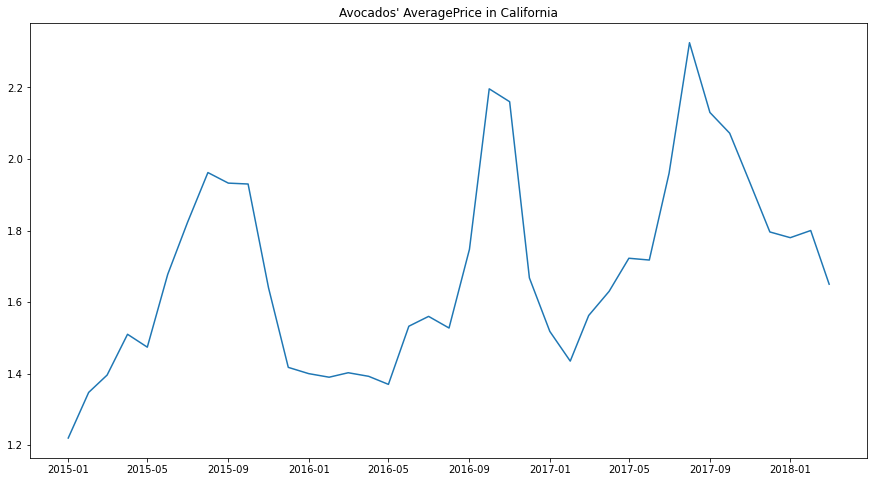

In [57]:
plt.figure(figsize=(15,8))
plt.plot(df_ts1)
plt.title("Avocados' AveragePrice in California")
plt.show()

In [58]:
decompose_result = seasonal_decompose(df_ts1, model='Mmultiplicative')
decompose_result

<Figure size 1080x288 with 0 Axes>

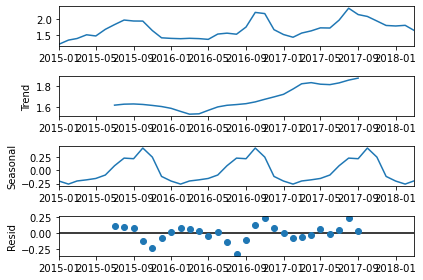

In [59]:
plt.figure(figsize=(15,4))
decompose_result.plot()
plt.show()

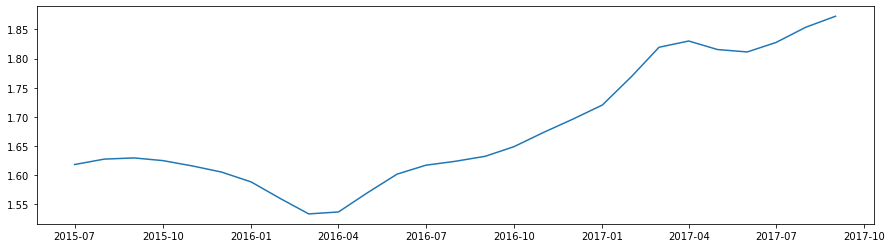

In [60]:
plt.figure(figsize=(15,4))
plt.plot(decompose_result.trend)
plt.show()

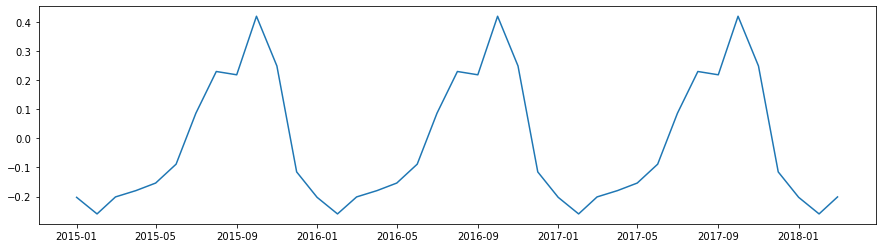

In [61]:
plt.figure(figsize=(15,4))
plt.plot(decompose_result.seasonal)
plt.show()

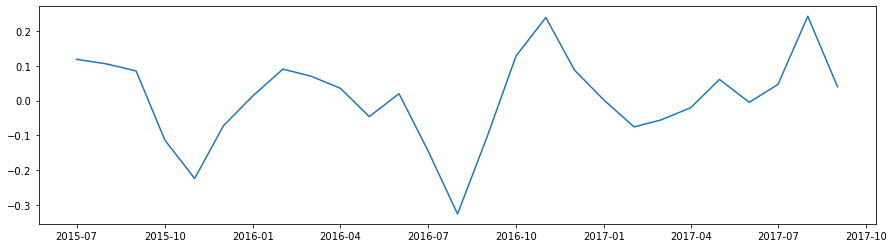

In [62]:
plt.figure(figsize=(15,4))
plt.plot(decompose_result.resid)
plt.show()

With the above result, we can clearly see the seasonal component of the data, and also see that trenf is nonlinear. Residual ranges from 0.85 => 1.15

Cuoc 4&5: Modeling & Evaluation/Analyze and Report

Arima

In [63]:
stepwise_model = auto_arima(df_ts1, start_p=2, start_q=2,
                           max_p=3, max_q=3, m=12,
                           start_P=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-10.252, Time=0.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=0.610, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-11.187, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1.204, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-9.729, Time=0.26 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-9.727, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-7.729, Time=0.47 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-13.157, Time=0.15 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-11.726, Time=0.72 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-11.724, Time=0.17 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-9.726, Time=0.29 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-12.336, T

In [64]:
print(stepwise_model.aic())

-13.15651879794503


In [65]:
df_ts1.shape

(39, 1)

In [66]:
train = df_ts1.loc['2015-01-01':'2017-06-01']
test = df_ts1.loc['2017-06-01':]

In [67]:
len(test)

10

In [68]:
#Fit model
stepwise_model.fit(train)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [69]:
future_forecast = stepwise_model.predict(n_predict=len(test))

In [70]:
future_forecast

array([1.65994321, 1.50293456, 1.9035445 , 2.67851778, 2.82638521,
       2.13843558, 1.89338242, 1.75753863, 1.9682857 , 2.09188698])

In [71]:
rmse = sqrt(mean_squared_error(test,future_forecast))
rmse

0.3918924140936411

In [72]:
mae = mean_absolute_error(test, future_forecast)
mae

0.3174932775955324

In [73]:
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=['Prediction'])

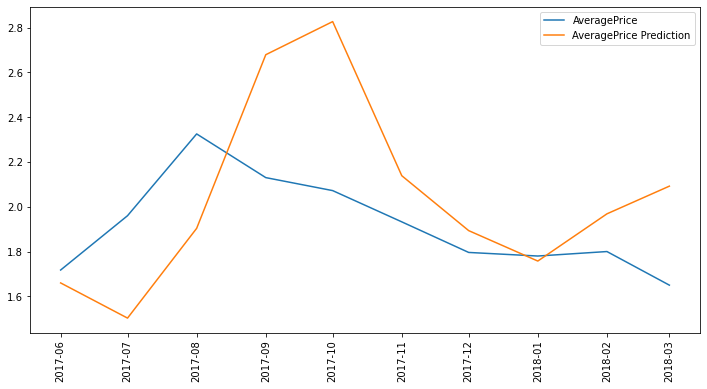

In [74]:
#Visualize the result
plt.figure(figsize=(12,6))
plt.plot(test, label='AveragePrice')
plt.plot(future_forecast, label='AveragePrice Prediction')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

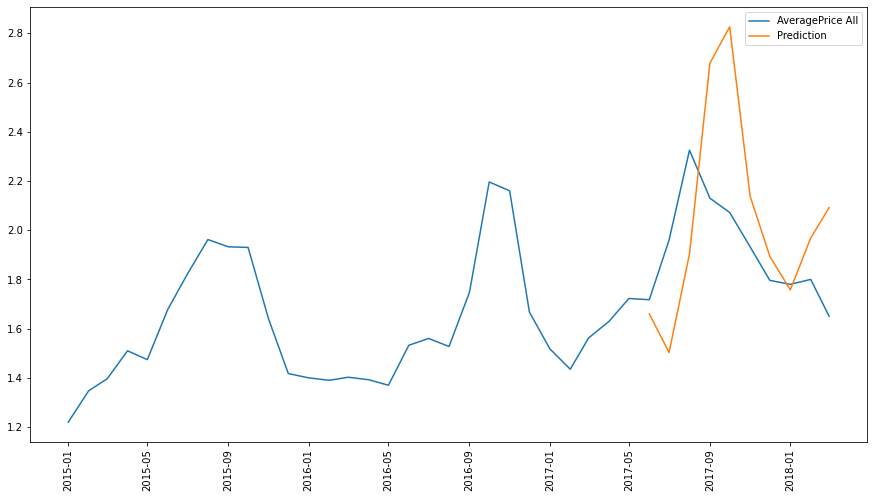

In [75]:
plt.figure(figsize=(15,8))
plt.plot(df_ts1, label='AveragePrice All')
plt.plot(future_forecast, label='Prediction')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

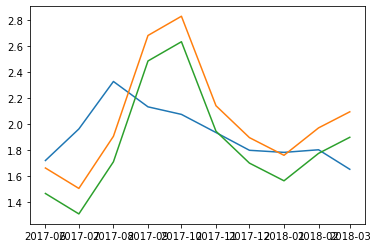

In [76]:
plt.plot(test, label='AveragePrice')
plt.plot(future_forecast, label='Prediction')
plt.plot(future_forecast-0.5*rmse, label='Prediction')

Because the increase and decrease is not uniform , it is difficult to find and adaptive value
(Vi su tang giam khong dong deu nen kho tim duoc gia tri thich nghi)

Prediction for the next 12 months

In [77]:
future_forecast_12 = stepwise_model.predict(n_periods=len(test)+12)
future_forecast_12

array([1.65994321, 1.50293456, 1.9035445 , 2.67851778, 2.82638521,
       2.13843558, 1.89338242, 1.75753863, 1.9682857 , 2.09188698,
       2.26763405, 2.14138289, 2.02225455, 1.77511563, 2.30646686,
       3.31777008, 3.59873686, 2.76930366, 2.45508077, 2.28098402,
       2.5519926 , 2.71620491])

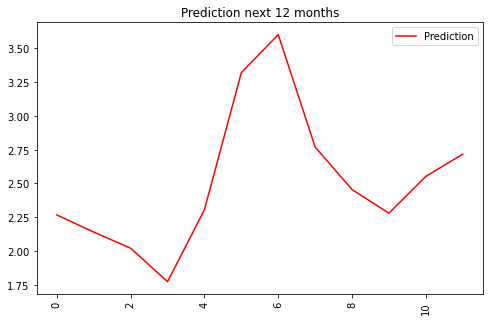

In [78]:
plt.figure(figsize=(8,5))
plt.plot(future_forecast_12[len(test):], color='red', label='Prediction')
plt.xticks(rotation='vertical')
plt.title('Prediction next 12 months')
plt.legend()
plt.show()

In [79]:
future_forecast_12[len(test):]

array([2.26763405, 2.14138289, 2.02225455, 1.77511563, 2.30646686,
       3.31777008, 3.59873686, 2.76930366, 2.45508077, 2.28098402,
       2.5519926 , 2.71620491])

In [80]:
months = pd.date_range('2018-04-01', '2019-03-01', freq='MS').strftime("%Y-%m-%d").tolist()

In [81]:
new_prdict = pd.DataFrame({
    'ds' : months,
    'y': future_forecast_12[len(test):]
})
new_prdict

ds         y
0   2018-04-01  2.267634
1   2018-05-01  2.141383
2   2018-06-01  2.022255
3   2018-07-01  1.775116
4   2018-08-01  2.306467
5   2018-09-01  3.317770
6   2018-10-01  3.598737
7   2018-11-01  2.769304
8   2018-12-01  2.455081
9   2019-01-01  2.280984
10  2019-02-01  2.551993
11  2019-03-01  2.716205

+ Because of the small amount of data(just over 3 years), the prediction of organic avocado's Average Price in California isn't accurate,
mae ~ 0.32 (about~20% of the mean AveragePrice),which is quite high compared to the AveragePrice of ~ 1.68)
+ Try another prediction algorithm: Prophet (of Facebook)

In [82]:
# Prophet

In [83]:
# create test dataset, remove last 10 months
train = df_ts.drop(df_ts.index[-10:])
train.tail()

ds       y
24 2017-01-01  1.5180
25 2017-02-01  1.4350
26 2017-03-01  1.5625
27 2017-04-01  1.6300
28 2017-05-01  1.7225

In [84]:
test = df_ts.drop(df_ts.index[0:-10])
test

ds       y
29 2017-06-01  1.7175
30 2017-07-01  1.9600
31 2017-08-01  2.3250
32 2017-09-01  2.1300
33 2017-10-01  2.0720
34 2017-11-01  1.9325
35 2017-12-01  1.7960
36 2018-01-01  1.7800
37 2018-02-01  1.8000
38 2018-03-01  1.6500

In [85]:
len(test)

10

# Build model

In [86]:
model = Prophet(yearly_seasonality=True, \
               daily_seasonality=False, weekly_seasonality=False)

In [87]:
model.fit(train)

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


In [88]:
# 10 month in test and 12 month to predict new values
months = pd.date_range('2017-06-01','2019-03-01',
                    freq='MS').strftime("%Y-%m-%d").tolist()
future = pd.DataFrame(months)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

In [89]:
#Use the model to make a forecast
forecast = model.predict(future)

In [90]:
forecast[["ds",'yhat']].head(10)

ds      yhat
0 2017-06-01  1.881961
1 2017-07-01  1.954895
2 2017-08-01  1.981544
3 2017-09-01  2.118380
4 2017-10-01  2.410878
5 2017-11-01  2.283110
6 2017-12-01  1.880950
7 2018-01-01  1.714532
8 2018-02-01  1.724829
9 2018-03-01  1.843153

In [91]:
#calculate MAE/RWSE between expected and predicted values for december
y_test = test['y'].values
y_pred = forecast['yhat'].values[:10]
mae_p = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' %mae_p)

MAE: 0.163


+ This result shows that prophet's rmse and mae are better than ARIMA Although the amount of data is small (just over 3 years), it is acceptable to predict the organic avocado AveragePrice in California, mae = 0.16(about 10% of AveragePrice), compared to the AveragePrice ~1.68.
+ We can see that Prophet (Facebooks) algorihm give better results

# Choose Prophet for predicting avocado prices in California in near future

In [92]:
y_test

array([1.7175, 1.96  , 2.325 , 2.13  , 2.072 , 1.9325, 1.796 , 1.78  ,
       1.8   , 1.65  ])

In [93]:
y_pred

array([1.88196075, 1.9548951 , 1.98154393, 2.11837972, 2.41087761,
       2.28311005, 1.88094987, 1.71453189, 1.72482913, 1.84315263])

In [94]:
y_test_value = pd.DataFrame(y_test, index = pd.to_datetime(test['ds']), columns=['Actual'])
y_pred_value = pd.DataFrame(y_pred, index = pd.to_datetime(test['ds']), columns=['Prediction'])

In [95]:
y_test_value

Actual
ds                
2017-06-01  1.7175
2017-07-01  1.9600
2017-08-01  2.3250
2017-09-01  2.1300
2017-10-01  2.0720
2017-11-01  1.9325
2017-12-01  1.7960
2018-01-01  1.7800
2018-02-01  1.8000
2018-03-01  1.6500

In [96]:
y_pred_value

Prediction
ds                    
2017-06-01    1.881961
2017-07-01    1.954895
2017-08-01    1.981544
2017-09-01    2.118380
2017-10-01    2.410878
2017-11-01    2.283110
2017-12-01    1.880950
2018-01-01    1.714532
2018-02-01    1.724829
2018-03-01    1.843153

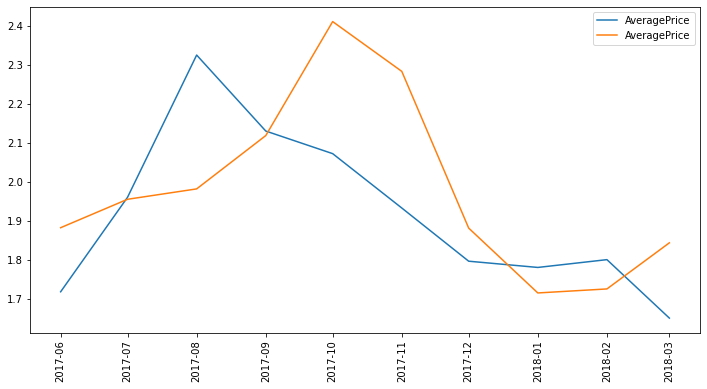

In [97]:
#Visualize thre result
plt.figure(figsize=(12,6))
plt.plot(y_test_value, label='AveragePrice')
plt.plot(y_pred_value, label='AveragePrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

<ipython-input-98-fc727835a72a>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


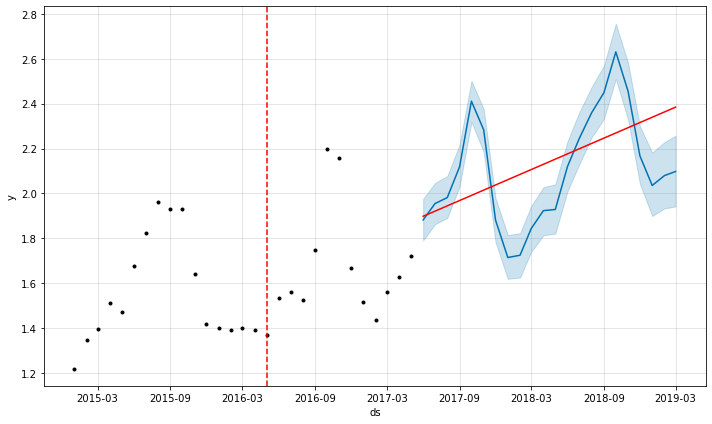

In [98]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), model, forecast)

<ipython-input-99-a8e790e14005>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


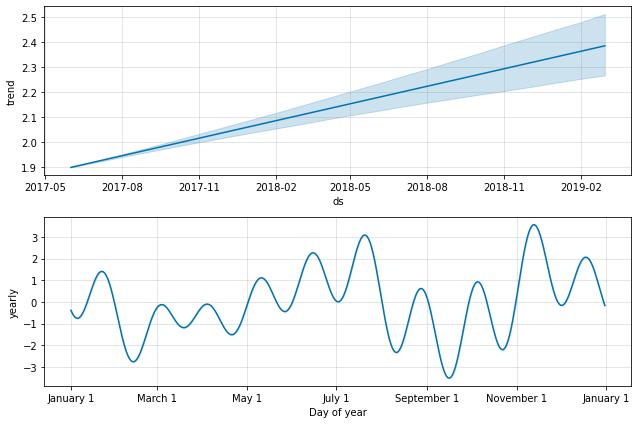

In [99]:
fig1 =model.plot_components(forecast)
fig1.show()

Prediction for next 12 months

In [100]:
forecast[['ds','yhat']].tail(12)

ds      yhat
10 2018-04-01  1.923462
11 2018-05-01  1.928491
12 2018-06-01  2.120709
13 2018-07-01  2.246075
14 2018-08-01  2.359688
15 2018-09-01  2.448747
16 2018-10-01  2.630615
17 2018-11-01  2.455103
18 2018-12-01  2.167083
19 2019-01-01  2.035512
20 2019-02-01  2.079483
21 2019-03-01  2.097786

Long-term prediction for the next 5 years ==> Consider whether to expand Cultivation/production, and trading

In [101]:
m = Prophet(yearly_seasonality=True, \
               daily_seasonality=False, weekly_seasonality=False)
m.fit(df_ts)
future = m.make_future_dataframe(periods=12*5, freq="M") # next 5 years

In [102]:
forecast = m.predict(future)

In [103]:
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper','trend', 'trend_lower', 'trend_upper' ]].tail(12)

ds      yhat  yhat_lower  yhat_upper     trend  trend_lower  \
87 2022-03-31  2.506902    2.316667    2.692812  2.696619     2.571577   
88 2022-04-30  2.329192    2.129525    2.530939  2.711244     2.582209   
89 2022-05-31  2.532630    2.324807    2.719576  2.726357     2.592102   
90 2022-06-30  2.855966    2.649393    3.057166  2.740981     2.603952   
91 2022-07-31  3.295002    3.089266    3.510858  2.756094     2.614565   
92 2022-08-31  3.164768    2.965930    3.369952  2.771206     2.625773   
93 2022-09-30  2.911124    2.701096    3.116340  2.785831     2.636791   
94 2022-10-31  2.574144    2.364499    2.784669  2.800944     2.649136   
95 2022-11-30  2.736732    2.517991    2.952802  2.815569     2.660446   
96 2022-12-31  2.715594    2.503054    2.918822  2.830681     2.670492   
97 2023-01-31  2.799748    2.587800    3.013752  2.845794     2.680886   
98 2023-02-28  2.555936    2.315751    2.791282  2.859444     2.690591   

    trend_upper  
87     2.830884  
88     2.849274  
89     2.869249  
90     2.887671  
91     2.908135  
92     2.928407  
93     2.947702  
94     2.967554  
95     2.986735  
96     3.005639  
97     3.024445  
98     3.041479

In [104]:
forecast.shape

(99, 16)

<ipython-input-105-dff77b8c9024>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


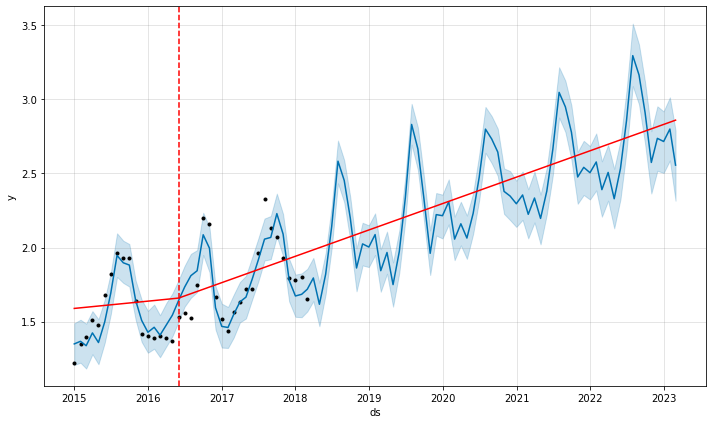

In [105]:
fig = m.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), m, forecast)

<ipython-input-106-b4b7495d9b67>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


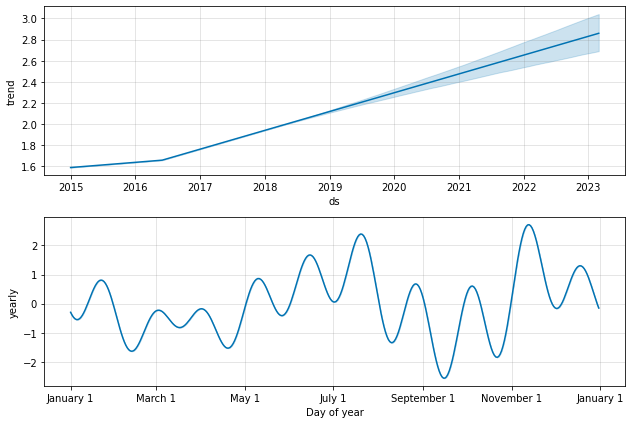

In [106]:
fig1 =m.plot_components(forecast)
fig1.show()

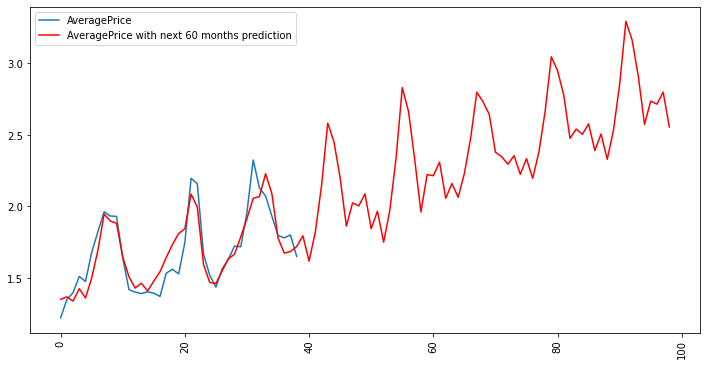

In [107]:
plt.figure(figsize=(12,6))
plt.plot(df_ts['y'], label='AveragePrice')
plt.plot(forecast['yhat'], label='AveragePrice with next 60 months prediction',
        color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

Base on the above results , we can see that it is possile to expand the cultivation/production and trading of organic avocados in California

Request 3: conventional Avocado Average Price Prediction for the future in California (0.3)

In [108]:
# Make new dataframe from orginal dataframe: data
df_ca = data[data['region'] == 'California']
df_ca['Date'] = df_ca['Date'].str[:-3]
df_ca = df_ca[data['type'] == 'conventional']

<ipython-input-108-ce87fd36ac68>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['Date'] = df_ca['Date'].str[:-3]
<ipython-input-108-ce87fd36ac68>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ca = df_ca[data['type'] == 'conventional']


In [109]:
df_ca.shape

(169, 13)

In [110]:
agg = {'AveragePrice': 'mean'}
df_ca_gr = df_ca.groupby(df_ca['Date']).aggregate(agg).reset_index()
df_ca_gr.head()

Date  AveragePrice
0  2015-01        0.9825
1  2015-02        0.9200
2  2015-03        1.0040
3  2015-04        1.0950
4  2015-05        0.9940

In [111]:
df_ts = pd.DataFrame()
df_ts['ds'] = pd.to_datetime(df_ca_gr['Date'])
df_ts['y'] = df_ca_gr['AveragePrice']
df_ts.head()

ds       y
0 2015-01-01  0.9825
1 2015-02-01  0.9200
2 2015-03-01  1.0040
3 2015-04-01  1.0950
4 2015-05-01  0.9940

In [112]:
df_ts.tail()

ds       y
34 2017-11-01  1.2150
35 2017-12-01  1.0380
36 2018-01-01  1.1850
37 2018-02-01  0.9775
38 2018-03-01  1.0750

In [113]:
df_ts.shape

(39, 2)

In [114]:
# Mean of conventinal Avocado AveragePrice in California
df_ts['y'].mean()

1.1050769230769228

In [115]:
df_ca.shape

agg = {'AveragePrice': 'mean'}
df_ca_gr = df_ca.groupby(df_ca['Date']).aggregate(agg).reset_index()
df_ca_gr.head()

df_ts = pd.DataFrame()
df_ts['ds'] = pd.to_datetime(df_ca_gr['Date'])
df_ts['y'] = df_ca_gr['AveragePrice']
df_ts.head()

df_ts.tail()

df_ts.shape

# Mean of Organic Avocado AveragePrice in California
df_ts['y'].mean()

1.1050769230769228

In [116]:
# Prophet

In [117]:
# create test dataset, remove last 10 months
train = df_ts.drop(df_ts.index[-10:])
train.tail()

ds      y
24 2017-01-01  0.868
25 2017-02-01  0.840
26 2017-03-01  1.275
27 2017-04-01  1.240
28 2017-05-01  1.230

In [118]:
test = df_ts.drop(df_ts.index[0:-10])
test

ds       y
29 2017-06-01  1.1925
30 2017-07-01  1.3780
31 2017-08-01  1.5100
32 2017-09-01  1.7050
33 2017-10-01  1.5840
34 2017-11-01  1.2150
35 2017-12-01  1.0380
36 2018-01-01  1.1850
37 2018-02-01  0.9775
38 2018-03-01  1.0750

In [119]:
len(test)

10

# Build model

In [120]:
model = Prophet(yearly_seasonality=True, \
               daily_seasonality=False, weekly_seasonality=False)

In [121]:
model.fit(train)

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


In [122]:
# 10 month in test and 12 month to predict new values
months = pd.date_range('2017-06-01','2019-03-01',
                    freq='MS').strftime("%Y-%m-%d").tolist()
future = pd.DataFrame(months)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

In [123]:
#Use the model to make a forecast
forecast = model.predict(future)

In [124]:
forecast[["ds",'yhat']].head(10)

ds      yhat
0 2017-06-01  1.316632
1 2017-07-01  1.456511
2 2017-08-01  1.414824
3 2017-09-01  1.472478
4 2017-10-01  1.648892
5 2017-11-01  1.625725
6 2017-12-01  1.306260
7 2018-01-01  1.266716
8 2018-02-01  1.257647
9 2018-03-01  1.481281

In [125]:
#calculate MAE/RWSE between expected and predicted values for december
y_test = test['y'].values
y_pred = forecast['yhat'].values[:10]
mae_p = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' %mae_p)

MAE: 0.204


+ it is acceptable to predict the conventinal avocado AveragePrice in California, mae = 0.20(about 20% of AveragePrice), compared to the AveragePrice ~1.10.

# Choose Prophet for predicting avocado prices in California in near future

In [126]:
y_test

array([1.1925, 1.378 , 1.51  , 1.705 , 1.584 , 1.215 , 1.038 , 1.185 ,
       0.9775, 1.075 ])

In [127]:
y_pred

array([1.31663186, 1.4565112 , 1.41482419, 1.47247764, 1.64889229,
       1.62572493, 1.30626022, 1.26671647, 1.2576466 , 1.48128087])

In [128]:
y_test_value = pd.DataFrame(y_test, index = pd.to_datetime(test['ds']), columns=['Actual'])
y_pred_value = pd.DataFrame(y_pred, index = pd.to_datetime(test['ds']), columns=['Prediction'])

In [129]:
y_test_value

Actual
ds                
2017-06-01  1.1925
2017-07-01  1.3780
2017-08-01  1.5100
2017-09-01  1.7050
2017-10-01  1.5840
2017-11-01  1.2150
2017-12-01  1.0380
2018-01-01  1.1850
2018-02-01  0.9775
2018-03-01  1.0750

In [130]:
y_pred_value

Prediction
ds                    
2017-06-01    1.316632
2017-07-01    1.456511
2017-08-01    1.414824
2017-09-01    1.472478
2017-10-01    1.648892
2017-11-01    1.625725
2017-12-01    1.306260
2018-01-01    1.266716
2018-02-01    1.257647
2018-03-01    1.481281

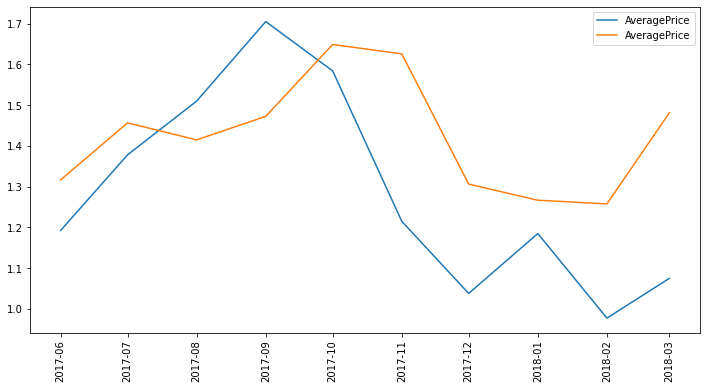

In [131]:
#Visualize thre result
plt.figure(figsize=(12,6))
plt.plot(y_test_value, label='AveragePrice')
plt.plot(y_pred_value, label='AveragePrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

<ipython-input-132-fc727835a72a>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


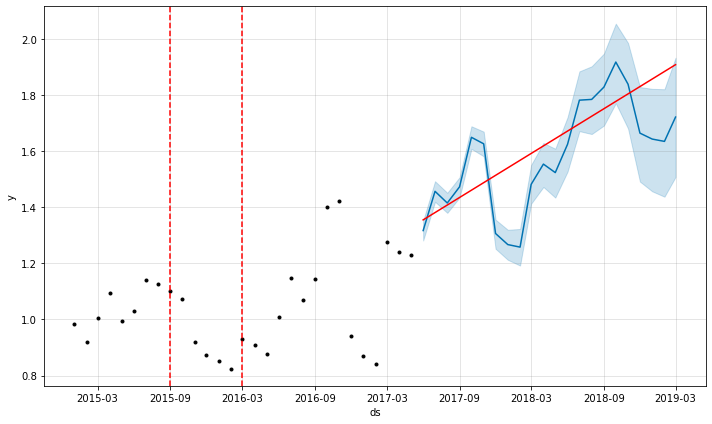

In [132]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), model, forecast)

<ipython-input-133-a8e790e14005>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


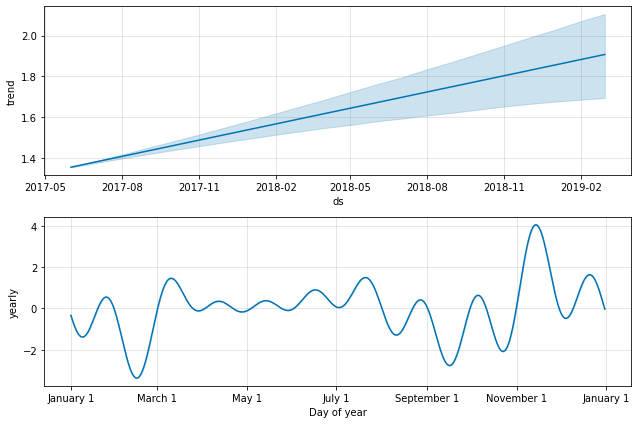

In [133]:
fig1 =model.plot_components(forecast)
fig1.show()

Prediction for next 12 months

In [134]:
forecast[['ds','yhat']].tail(12)

ds      yhat
10 2018-04-01  1.553438
11 2018-05-01  1.523199
12 2018-06-01  1.624073
13 2018-07-01  1.781250
14 2018-08-01  1.783940
15 2018-09-01  1.827863
16 2018-10-01  1.917028
17 2018-11-01  1.837950
18 2018-12-01  1.663807
19 2019-01-01  1.642651
20 2019-02-01  1.634363
21 2019-03-01  1.721042

Long-term prediction for the next 5 years ==> Consider whether to expand Cultivation/production, and trading

In [135]:
m = Prophet(yearly_seasonality=True, \
               daily_seasonality=False, weekly_seasonality=False)
m.fit(df_ts)
future = m.make_future_dataframe(periods=12*5, freq="M") # next 5 years

In [136]:
forecast = m.predict(future)

In [137]:
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper','trend', 'trend_lower', 'trend_upper' ]].tail(12)

ds      yhat  yhat_lower  yhat_upper     trend  trend_lower  \
87 2022-03-31  1.929791    1.765324    2.099492  1.920838     1.820935   
88 2022-04-30  1.808669    1.639568    1.983540  1.932449     1.830630   
89 2022-05-31  1.861899    1.696761    2.036779  1.944447     1.839408   
90 2022-06-30  2.084182    1.906932    2.263633  1.956058     1.848014   
91 2022-07-31  2.262959    2.080569    2.441770  1.968057     1.857039   
92 2022-08-31  2.236236    2.061693    2.411550  1.980055     1.865302   
93 2022-09-30  1.986521    1.796604    2.170798  1.991666     1.873269   
94 2022-10-31  1.683101    1.496025    1.865090  2.003664     1.882267   
95 2022-11-30  2.022829    1.846672    2.199892  2.015275     1.890726   
96 2022-12-31  2.044382    1.866432    2.240662  2.027274     1.899046   
97 2023-01-31  1.897644    1.698745    2.090017  2.039272     1.908304   
98 2023-02-28  1.654509    1.458922    1.843859  2.050109     1.915992   

    trend_upper  
87     2.028162  
88     2.043433  
89     2.058449  
90     2.072056  
91     2.086967  
92     2.102790  
93     2.117575  
94     2.132064  
95     2.146864  
96     2.161797  
97     2.178327  
98     2.192876

In [138]:
forecast.shape

(99, 16)

<ipython-input-139-dff77b8c9024>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


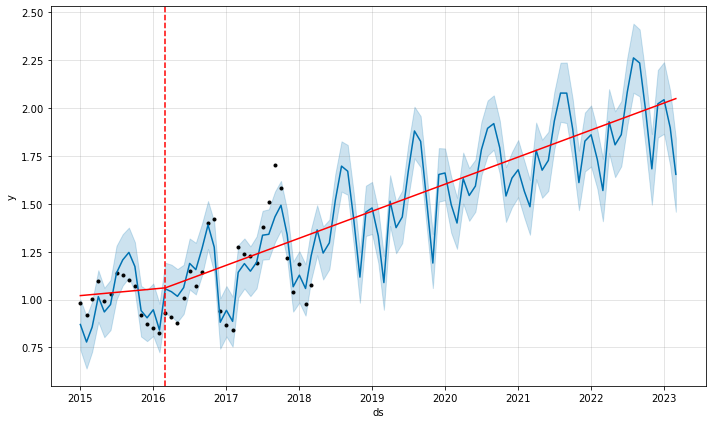

In [139]:
fig = m.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), m, forecast)

<ipython-input-140-b4b7495d9b67>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


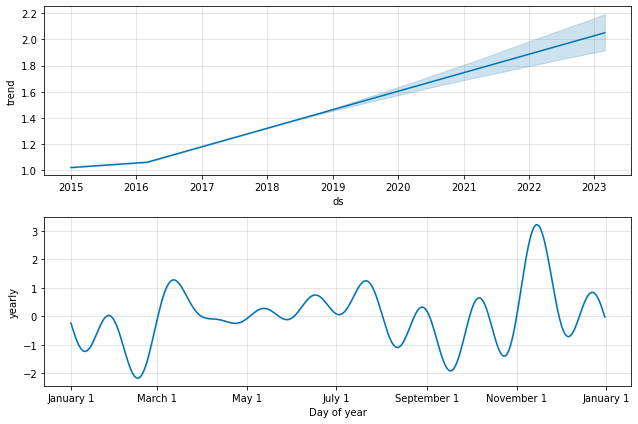

In [140]:
fig1 =m.plot_components(forecast)
fig1.show()

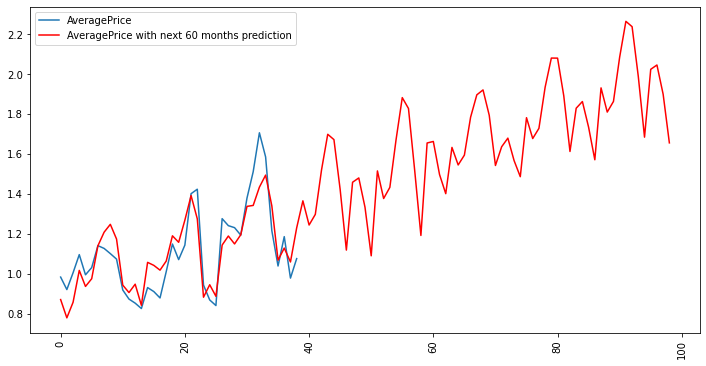

In [141]:
plt.figure(figsize=(12,6))
plt.plot(df_ts['y'], label='AveragePrice')
plt.plot(forecast['yhat'], label='AveragePrice with next 60 months prediction',
        color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

+ Base on the above results , we can see that it is possile to expand the cultivation/production and trading of organic avocados in California
+ Even conventional avocado is more potential because trend raise ratio (2017 -2023(predict)) of conventinal is higherthan organic

Request 4: Coose 1 Reginal have most potential to expand Avocado(organic and conventional) bussiness
Reason ?
prove it ?

In [142]:
#Potential = Quantity x Price 
data['Volume x Price'] = data['Total Volume'] * data['AveragePrice']
data.head(5)

Date  AveragePrice  Total Volume     4046       4225    4770  \
0  2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1  2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2  2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3  2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4  2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0     8696.87     8603.62       93.25          0.0  conventional  2015   
1     9505.56     9408.07       97.49          0.0  conventional  2015   
2     8145.35     8042.21      103.14          0.0  conventional  2015   
3     5811.16     5677.40      133.76          0.0  conventional  2015   
4     6183.95     5986.26      197.69          0.0  conventional  2015   

   region  Volume x Price  
0  Albany      85434.7046  
1  Albany      74083.9230  
2  Albany     109944.8046  
3  Albany      85311.5220  
4  Albany      65330.6880

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


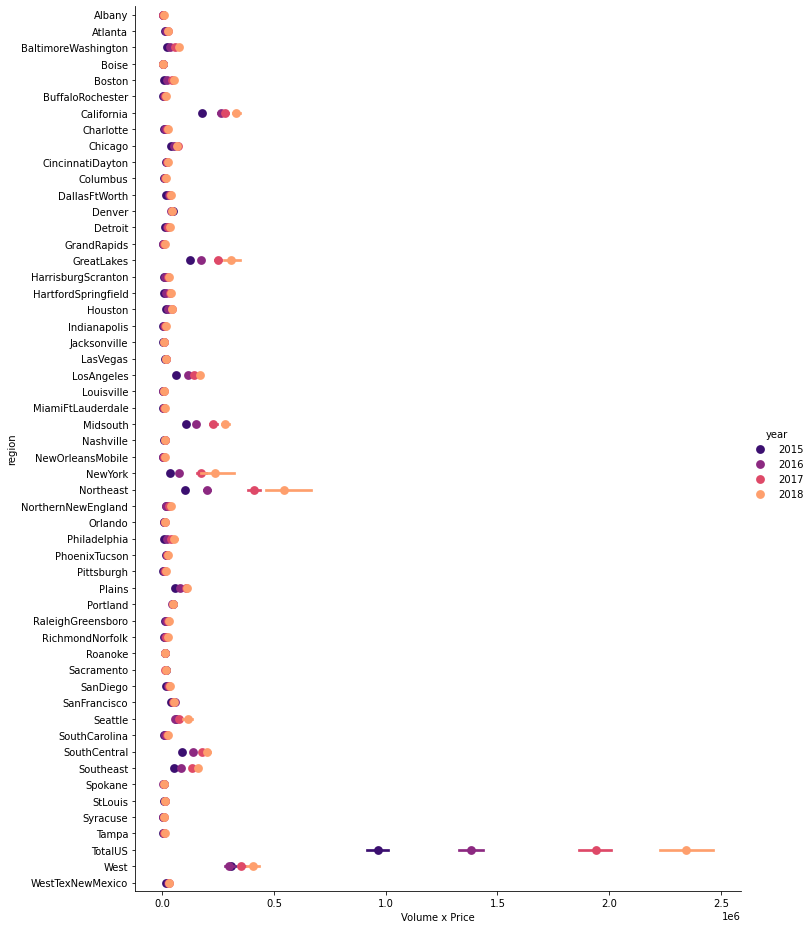

In [143]:
mask = data['type']=='organic'
g = sns.factorplot('Volume x Price','region',data=data[mask],
                   hue='year',
                   size=13,
                   aspect=0.8,
                   palette='magma',
                   join=False,
              )

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


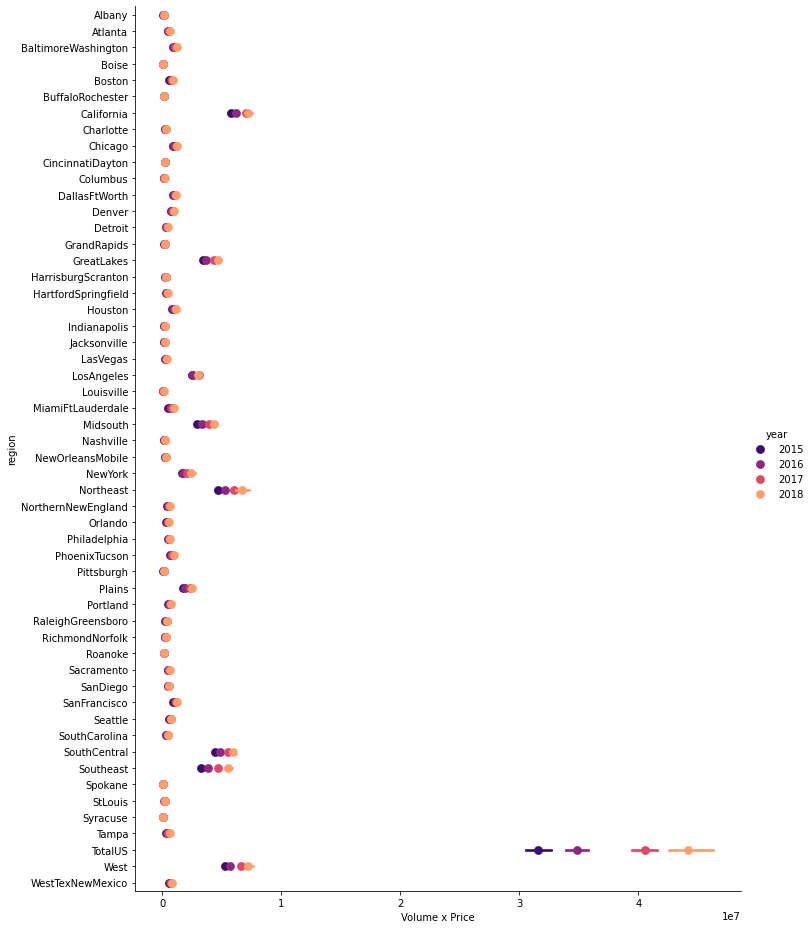

In [144]:
mask = data['type']=='conventional'
g = sns.factorplot('Volume x Price','region',data=data[mask],
                   hue='year',
                   size=13,
                   aspect=0.8,
                   palette='magma',
                   join=False,
                  )

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


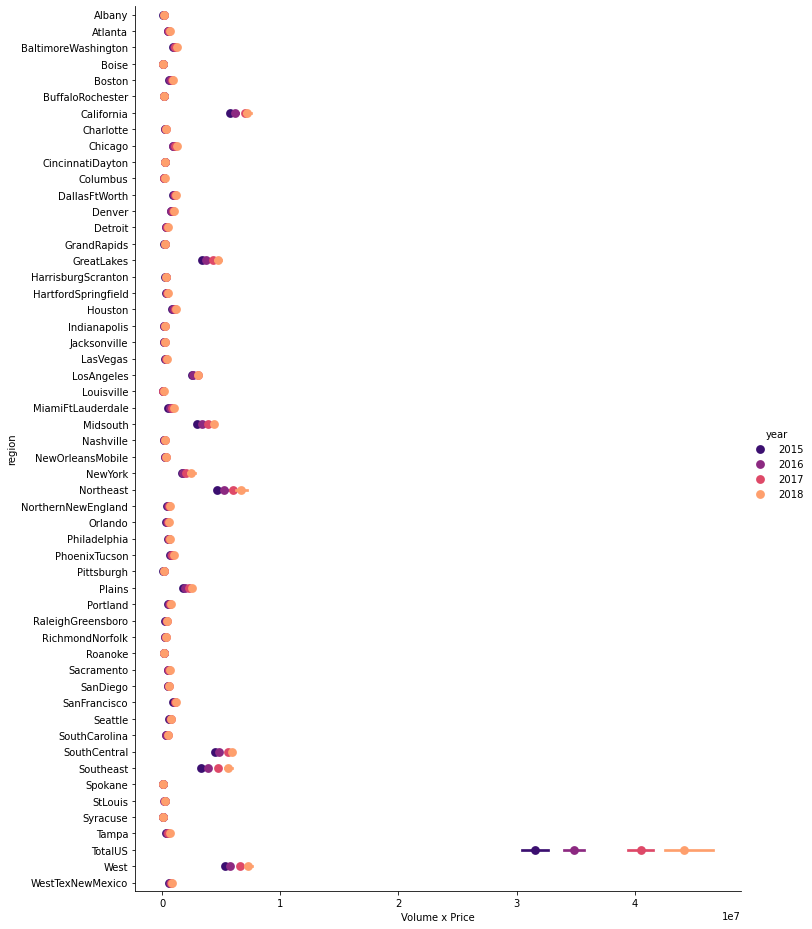

In [145]:
#mask = data['type']=='conventional'
g = sns.factorplot('Volume x Price','region',data=data[mask],
                   hue='year',
                   size=13,
                   aspect=0.8,
                   palette='magma',
                   join=False,
              )

Choose West to expand business Avocado because:
+ Potential = Price x Volume
+ West have highest point(except TotalUS but we don't choose totalUS because it is whole country)
+ And we should focus to conventional because:
+ In conventional, West have 1st point
+ In organic, West have 2nd point

we analyze West-Organic

In [146]:
# Make new dataframe from orginal dataframe: data
df_we = data[data['region'] == 'West']
df_we['Date'] = df_we['Date'].str[:-3]
df_we = df_we[data['type'] == 'organic']

<ipython-input-146-054759d1897d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_we['Date'] = df_we['Date'].str[:-3]
<ipython-input-146-054759d1897d>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_we = df_we[data['type'] == 'organic']


In [147]:
df_we.shape

(169, 14)

In [148]:
agg = {'AveragePrice': 'mean'}
df_we_gr = df_we.groupby(df_we['Date']).aggregate(agg).reset_index()
df_we_gr.head()

Date  AveragePrice
0  2015-01         1.410
1  2015-02         1.450
2  2015-03         1.430
3  2015-04         1.510
4  2015-05         1.466

In [149]:
df_ts = pd.DataFrame()
df_ts['ds'] = pd.to_datetime(df_we_gr['Date'])
df_ts['y'] = df_we_gr['AveragePrice']
df_ts.head()

ds      y
0 2015-01-01  1.410
1 2015-02-01  1.450
2 2015-03-01  1.430
3 2015-04-01  1.510
4 2015-05-01  1.466

In [150]:
df_ts.tail()

ds       y
34 2017-11-01  1.9500
35 2017-12-01  1.4980
36 2018-01-01  1.7325
37 2018-02-01  1.5025
38 2018-03-01  1.6050

In [151]:
df_ts.shape

(39, 2)

In [152]:
# Mean of Organic Avocado AveragePrice in West
df_ts['y'].mean()

1.5609615384615385

Use df_ts1 for ARIMA, df_ts for Prophet

In [153]:
df_ts1 = df_ts.copy(deep=False)

In [154]:
df_ts1.index = pd.to_datetime(df_ts1.ds)

In [155]:
df_ts1.index

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [156]:
df_ts1.head()

ds      y
ds                          
2015-01-01 2015-01-01  1.410
2015-02-01 2015-02-01  1.450
2015-03-01 2015-03-01  1.430
2015-04-01 2015-04-01  1.510
2015-05-01 2015-05-01  1.466

In [157]:
df_ts1 = df_ts1.drop(['ds'], axis=1)

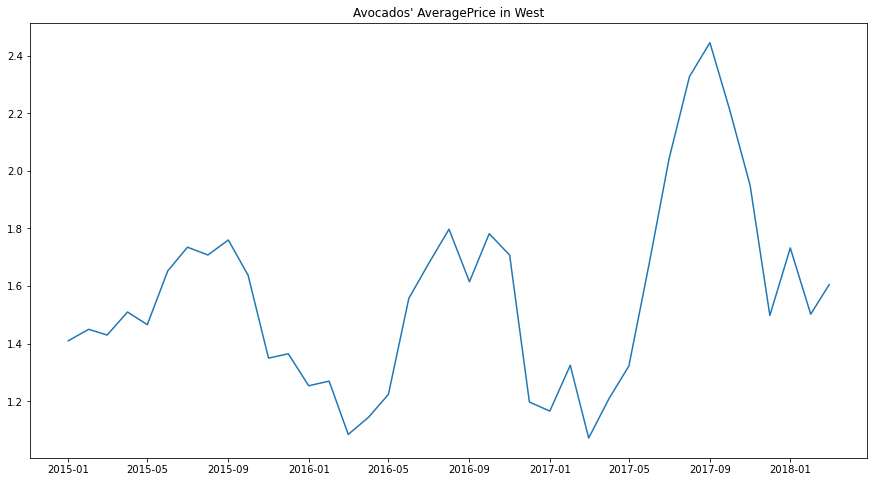

In [158]:
plt.figure(figsize=(15,8))
plt.plot(df_ts1)
plt.title("Avocados' AveragePrice in West")
plt.show()

In [159]:
decompose_result = seasonal_decompose(df_ts1, model='Mmultiplicative')
decompose_result

<Figure size 1080x288 with 0 Axes>

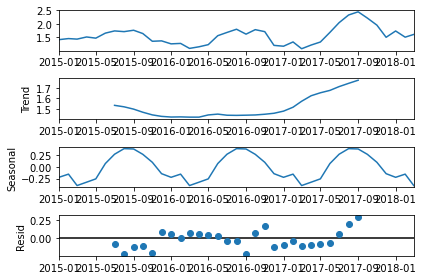

In [160]:
plt.figure(figsize=(15,4))
decompose_result.plot()
plt.show()

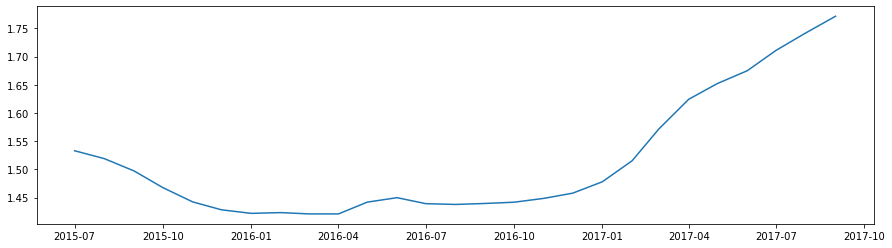

In [161]:
plt.figure(figsize=(15,4))
plt.plot(decompose_result.trend)
plt.show()

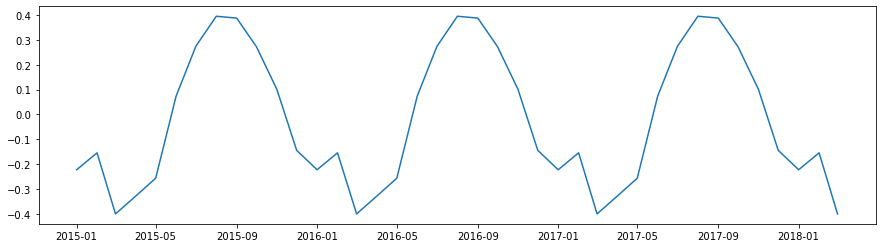

In [162]:
plt.figure(figsize=(15,4))
plt.plot(decompose_result.seasonal)
plt.show()

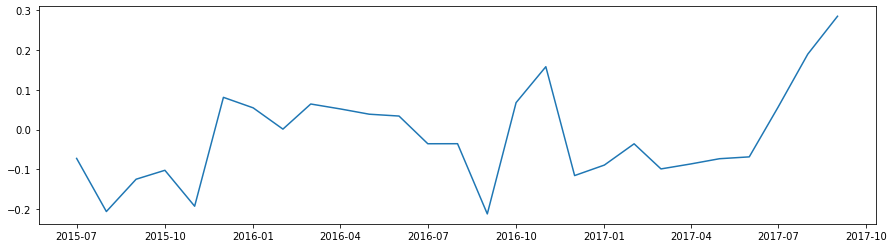

In [163]:
plt.figure(figsize=(15,4))
plt.plot(decompose_result.resid)
plt.show()

With the above result, we can clearly see the seasonal component of the data, and also see that trenf is nonlinear. Residual ranges from -0.2 => 0.3

Cuoc 4&5: Modeling & Evaluation/Analyze and Report

Arima

In [164]:
stepwise_model = auto_arima(df_ts1, start_p=2, start_q=2,
                           max_p=3, max_q=3, m=12,
                           start_P=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=4.162, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1.921, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2.260, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-2.895, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-3.513, Time=0.03 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-2.522, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-1.981, Time=0.05 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=-2.152, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1.935, Time=0.02 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=-0.230, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 1.510 seconds


In [165]:
print(stepwise_model.aic())

-3.5133135309512857


In [166]:
df_ts1.shape

(39, 1)

In [167]:
train = df_ts1.loc['2015-01-01':'2017-06-01']
test = df_ts1.loc['2017-06-01':]

In [168]:
len(test)

10

In [169]:
#Fit model
stepwise_model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [170]:
future_forecast = stepwise_model.predict(n_predict=len(test))

In [171]:
future_forecast

array([1.76510372, 1.88460372, 1.70210372, 1.86910372, 1.79460372,
       1.28460372, 1.25310372, 1.41210372, 1.15960372, 1.29710372])

In [172]:
rmse = sqrt(mean_squared_error(test,future_forecast))
rmse

0.4179439047119055

In [173]:
mae = mean_absolute_error(test, future_forecast)
mae

0.3742670244613019

In [174]:
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=['Prediction'])

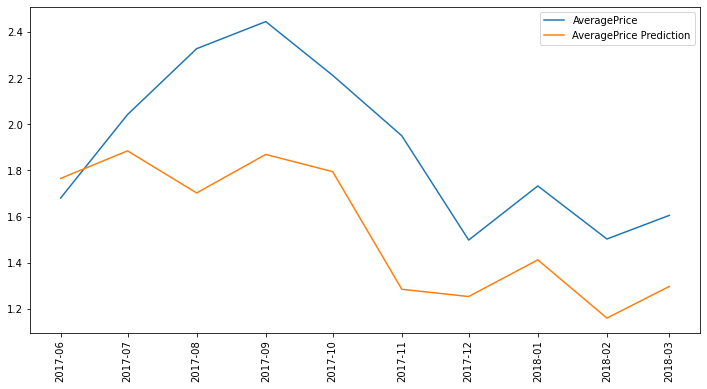

In [175]:
#Visualize the result
plt.figure(figsize=(12,6))
plt.plot(test, label='AveragePrice')
plt.plot(future_forecast, label='AveragePrice Prediction')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

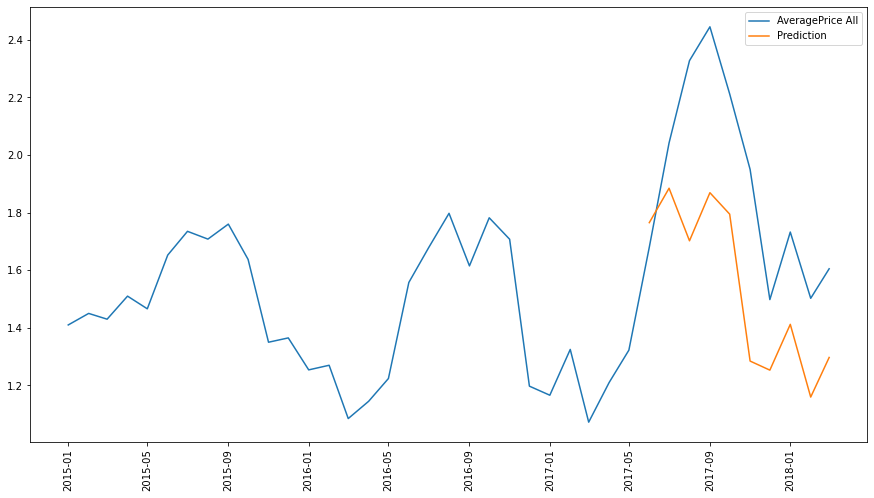

In [176]:
plt.figure(figsize=(15,8))
plt.plot(df_ts1, label='AveragePrice All')
plt.plot(future_forecast, label='Prediction')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

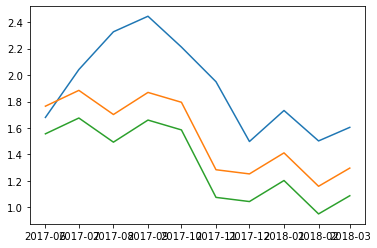

In [177]:
plt.plot(test, label='AveragePrice')
plt.plot(future_forecast, label='Prediction')
plt.plot(future_forecast-0.5*rmse, label='Prediction')

Because the increase and decrease is not uniform , it is difficult to find and adaptive value
(Vi su tang giam khong dong deu nen kho tim duoc gia tri thich nghi)

Prediction for the next 12 months

In [178]:
future_forecast_12 = stepwise_model.predict(n_periods=len(test)+12)
future_forecast_12

array([1.76510372, 1.88460372, 1.70210372, 1.86910372, 1.79460372,
       1.28460372, 1.25310372, 1.41210372, 1.15960372, 1.29710372,
       1.40960372, 1.76710372, 1.85220744, 1.97170744, 1.78920744,
       1.95620744, 1.88170744, 1.37170744, 1.34020744, 1.49920744,
       1.24670744, 1.38420744])

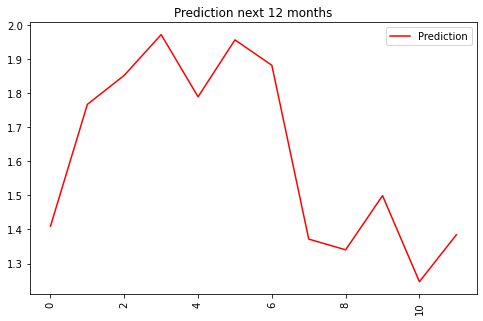

In [179]:
plt.figure(figsize=(8,5))
plt.plot(future_forecast_12[len(test):], color='red', label='Prediction')
plt.xticks(rotation='vertical')
plt.title('Prediction next 12 months')
plt.legend()
plt.show()

In [180]:
future_forecast_12[len(test):]

array([1.40960372, 1.76710372, 1.85220744, 1.97170744, 1.78920744,
       1.95620744, 1.88170744, 1.37170744, 1.34020744, 1.49920744,
       1.24670744, 1.38420744])

In [181]:
months = pd.date_range('2018-04-01', '2019-03-01', freq='MS').strftime("%Y-%m-%d").tolist()

In [182]:
new_prdict = pd.DataFrame({
    'ds' : months,
    'y': future_forecast_12[len(test):]
})
new_prdict

ds         y
0   2018-04-01  1.409604
1   2018-05-01  1.767104
2   2018-06-01  1.852207
3   2018-07-01  1.971707
4   2018-08-01  1.789207
5   2018-09-01  1.956207
6   2018-10-01  1.881707
7   2018-11-01  1.371707
8   2018-12-01  1.340207
9   2019-01-01  1.499207
10  2019-02-01  1.246707
11  2019-03-01  1.384207

+ Because of the small amount of data(just over 3 years), the prediction of organic avocado's Average Price in West isn't accurate,
+ Try another prediction algorithm: Prophet (of Facebook)

In [183]:
# Prophet

In [184]:
# create test dataset, remove last 10 months
train = df_ts.drop(df_ts.index[-10:])
train.tail()

ds       y
24 2017-01-01  1.1660
25 2017-02-01  1.3250
26 2017-03-01  1.0725
27 2017-04-01  1.2100
28 2017-05-01  1.3225

In [185]:
test = df_ts.drop(df_ts.index[0:-10])
test

ds       y
29 2017-06-01  1.6800
30 2017-07-01  2.0420
31 2017-08-01  2.3275
32 2017-09-01  2.4450
33 2017-10-01  2.2120
34 2017-11-01  1.9500
35 2017-12-01  1.4980
36 2018-01-01  1.7325
37 2018-02-01  1.5025
38 2018-03-01  1.6050

In [186]:
len(test)

10

# Build model

In [187]:
model = Prophet(yearly_seasonality=True, \
               daily_seasonality=False, weekly_seasonality=False)

In [188]:
model.fit(train)

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


In [189]:
# 10 month in test and 12 month to predict new values
months = pd.date_range('2017-06-01','2019-03-01',
                    freq='MS').strftime("%Y-%m-%d").tolist()
future = pd.DataFrame(months)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

In [190]:
#Use the model to make a forecast
forecast = model.predict(future)

In [191]:
forecast[["ds",'yhat']].head(10)

ds      yhat
0 2017-06-01  1.561504
1 2017-07-01  1.666456
2 2017-08-01  1.735784
3 2017-09-01  1.634362
4 2017-10-01  1.713967
5 2017-11-01  1.578679
6 2017-12-01  1.252243
7 2018-01-01  1.193418
8 2018-02-01  1.320625
9 2018-03-01  1.148162

In [192]:
#calculate MAE/RWSE between expected and predicted values for december
y_test = test['y'].values
y_pred = forecast['yhat'].values[:10]
mae_p = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' %mae_p)

MAE: 0.419


+ This result shows that prophet's rmse and mae are little higher than ARIMA (0.419 vs 0.374) but prophet have more tool visualize (better chart)
+ We can see that Prophet (Facebooks) algorihm give nearly same as results with ARIMA
+ we choose Prophet algorihm

# Choose Prophet for predicting avocado prices in West in near future

In [193]:
y_test

array([1.68  , 2.042 , 2.3275, 2.445 , 2.212 , 1.95  , 1.498 , 1.7325,
       1.5025, 1.605 ])

In [194]:
y_pred

array([1.56150397, 1.66645618, 1.73578369, 1.63436202, 1.71396659,
       1.57867941, 1.25224322, 1.19341798, 1.32062521, 1.14816228])

In [195]:
y_test_value = pd.DataFrame(y_test, index = pd.to_datetime(test['ds']), columns=['Actual'])
y_pred_value = pd.DataFrame(y_pred, index = pd.to_datetime(test['ds']), columns=['Prediction'])

In [196]:
y_test_value

Actual
ds                
2017-06-01  1.6800
2017-07-01  2.0420
2017-08-01  2.3275
2017-09-01  2.4450
2017-10-01  2.2120
2017-11-01  1.9500
2017-12-01  1.4980
2018-01-01  1.7325
2018-02-01  1.5025
2018-03-01  1.6050

In [197]:
y_pred_value

Prediction
ds                    
2017-06-01    1.561504
2017-07-01    1.666456
2017-08-01    1.735784
2017-09-01    1.634362
2017-10-01    1.713967
2017-11-01    1.578679
2017-12-01    1.252243
2018-01-01    1.193418
2018-02-01    1.320625
2018-03-01    1.148162

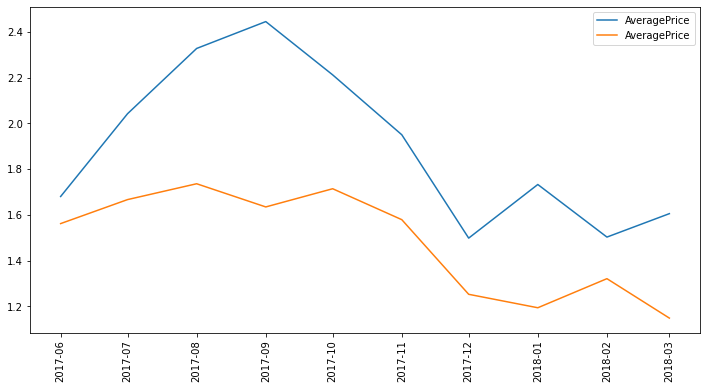

In [198]:
#Visualize thre result
plt.figure(figsize=(12,6))
plt.plot(y_test_value, label='AveragePrice')
plt.plot(y_pred_value, label='AveragePrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

<ipython-input-199-fc727835a72a>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


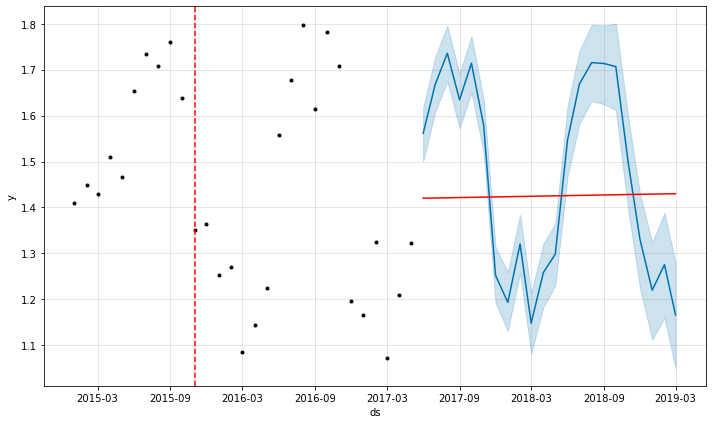

In [199]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), model, forecast)

<ipython-input-200-a8e790e14005>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


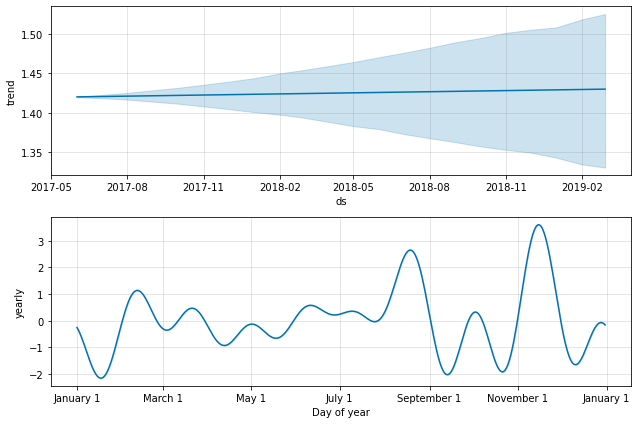

In [200]:
fig1 =model.plot_components(forecast)
fig1.show()

Prediction for next 12 months

In [201]:
forecast[['ds','yhat']].tail(12)

ds      yhat
10 2018-04-01  1.258665
11 2018-05-01  1.298381
12 2018-06-01  1.547195
13 2018-07-01  1.668648
14 2018-08-01  1.715321
15 2018-09-01  1.713361
16 2018-10-01  1.706793
17 2018-11-01  1.499944
18 2018-12-01  1.331106
19 2019-01-01  1.219878
20 2019-02-01  1.275571
21 2019-03-01  1.166158

Long-term prediction for the next 5 years ==> Consider whether to expand Cultivation/production, and trading

In [202]:
m = Prophet(yearly_seasonality=True, \
               daily_seasonality=False, weekly_seasonality=False)
m.fit(df_ts)
future = m.make_future_dataframe(periods=12*5, freq="M") # next 5 years

In [203]:
forecast = m.predict(future)

In [204]:
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper','trend', 'trend_lower', 'trend_upper' ]].tail(12)

ds      yhat  yhat_lower  yhat_upper     trend  trend_lower  \
87 2022-03-31  2.946896    2.559766    3.369174  3.103998     2.736040   
88 2022-04-30  2.942367    2.515999    3.376434  3.128728     2.749460   
89 2022-05-31  3.205224    2.777330    3.633283  3.154282     2.761128   
90 2022-06-30  3.467971    3.037459    3.934109  3.179012     2.773751   
91 2022-07-31  3.474523    3.041159    3.959255  3.204566     2.782498   
92 2022-08-31  3.901494    3.459343    4.375475  3.230121     2.795365   
93 2022-09-30  3.526005    3.075087    4.011952  3.254851     2.809200   
94 2022-10-31  3.010192    2.526410    3.481064  3.280405     2.820211   
95 2022-11-30  3.449591    2.971995    3.945990  3.305135     2.833960   
96 2022-12-31  3.157492    2.634003    3.655775  3.330690     2.845294   
97 2023-01-31  2.969592    2.440765    3.490501  3.356244     2.858717   
98 2023-02-28  3.098547    2.564282    3.627308  3.379325     2.869961   

    trend_upper  
87     3.478204  
88     3.510797  
89     3.553453  
90     3.585694  
91     3.621546  
92     3.663761  
93     3.698731  
94     3.728923  
95     3.768861  
96     3.809706  
97     3.848339  
98     3.885037

In [205]:
forecast.shape

(99, 16)

<ipython-input-206-dff77b8c9024>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


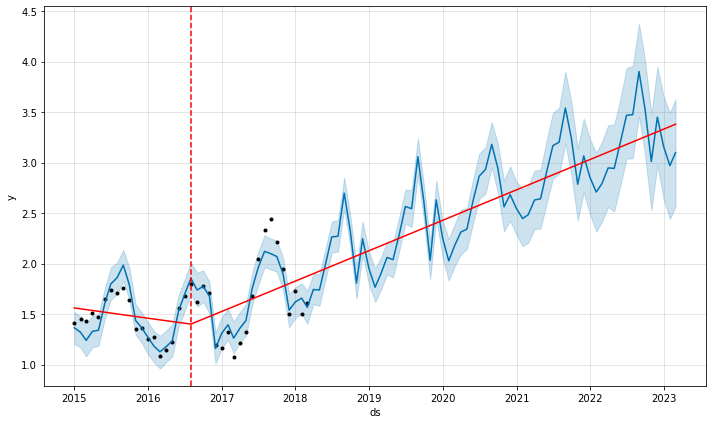

In [206]:
fig = m.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), m, forecast)

<ipython-input-207-b4b7495d9b67>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


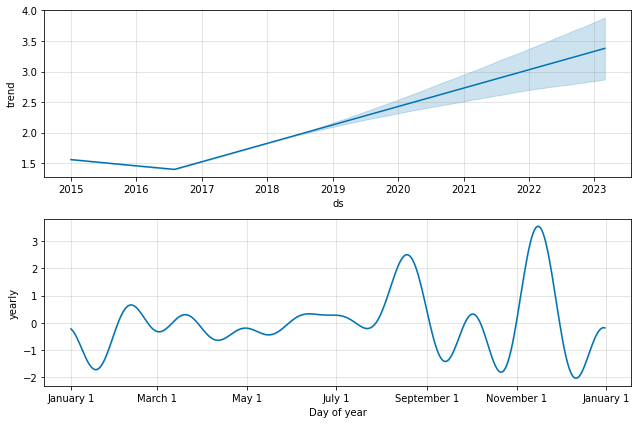

In [207]:
fig1 =m.plot_components(forecast)
fig1.show()

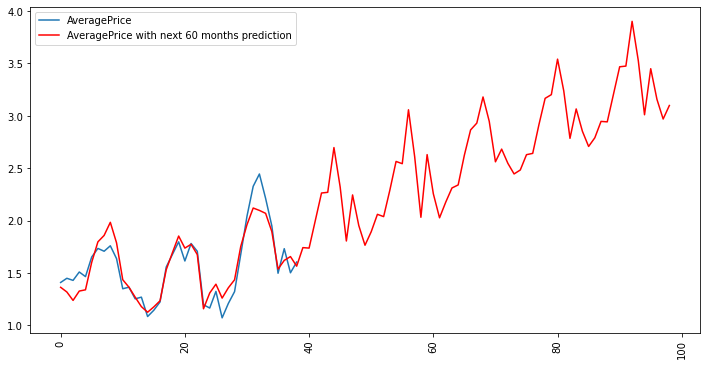

In [208]:
plt.figure(figsize=(12,6))
plt.plot(df_ts['y'], label='AveragePrice')
plt.plot(forecast['yhat'], label='AveragePrice with next 60 months prediction',
        color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

Base on the above results , we can see that it is possile to expand the cultivation/production and trading of organic avocados in West

In [209]:
# Make new dataframe from orginal dataframe: data
df_we = data[data['region'] == 'West']
df_we['Date'] = df_we['Date'].str[:-3]
df_we = df_we[data['type'] == 'conventional']

<ipython-input-209-d3d0644e85fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_we['Date'] = df_we['Date'].str[:-3]
<ipython-input-209-d3d0644e85fa>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_we = df_we[data['type'] == 'conventional']


In [210]:
df_we.shape

(169, 14)

In [211]:
agg = {'AveragePrice': 'mean'}
df_we_gr = df_we.groupby(df_we['Date']).aggregate(agg).reset_index()
df_we_gr.head()

Date  AveragePrice
0  2015-01        0.9350
1  2015-02        0.9150
2  2015-03        0.9600
3  2015-04        0.9275
4  2015-05        0.9340

In [212]:
df_ts = pd.DataFrame()
df_ts['ds'] = pd.to_datetime(df_ca_gr['Date'])
df_ts['y'] = df_we_gr['AveragePrice']
df_ts.head()

ds       y
0 2015-01-01  0.9350
1 2015-02-01  0.9150
2 2015-03-01  0.9600
3 2015-04-01  0.9275
4 2015-05-01  0.9340

In [213]:
df_ts.tail()

ds       y
34 2017-11-01  1.0725
35 2017-12-01  1.0060
36 2018-01-01  1.0450
37 2018-02-01  0.9275
38 2018-03-01  0.9700

In [214]:
df_ts.shape

(39, 2)

In [215]:
# Mean of conventinal Avocado AveragePrice in West
df_ts['y'].mean()

0.983897435897436

In [216]:
df_we.shape

agg = {'AveragePrice': 'mean'}
df_we_gr = df_we.groupby(df_we['Date']).aggregate(agg).reset_index()
df_we_gr.head()

df_ts = pd.DataFrame()
df_ts['ds'] = pd.to_datetime(df_we_gr['Date'])
df_ts['y'] = df_we_gr['AveragePrice']
df_ts.head()

df_ts.tail()

df_ts.shape

# Mean of Conventinal Avocado AveragePrice in West
df_ts['y'].mean()

0.983897435897436

In [217]:
# Prophet

In [218]:
# create test dataset, remove last 10 months
train = df_ts.drop(df_ts.index[-10:])
train.tail()

ds      y
24 2017-01-01  0.834
25 2017-02-01  0.790
26 2017-03-01  0.985
27 2017-04-01  1.002
28 2017-05-01  1.020

In [219]:
test = df_ts.drop(df_ts.index[0:-10])
test

ds       y
29 2017-06-01  1.0400
30 2017-07-01  1.1460
31 2017-08-01  1.3175
32 2017-09-01  1.5525
33 2017-10-01  1.4320
34 2017-11-01  1.0725
35 2017-12-01  1.0060
36 2018-01-01  1.0450
37 2018-02-01  0.9275
38 2018-03-01  0.9700

In [220]:
len(test)

10

# Build model

In [221]:
model = Prophet(yearly_seasonality=True, \
               daily_seasonality=False, weekly_seasonality=False)

In [222]:
model.fit(train)

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


In [223]:
# 10 month in test and 12 month to predict new values
months = pd.date_range('2017-06-01','2019-03-01',
                    freq='MS').strftime("%Y-%m-%d").tolist()
future = pd.DataFrame(months)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

In [224]:
#Use the model to make a forecast
forecast = model.predict(future)

In [225]:
forecast[["ds",'yhat']].head(10)

ds      yhat
0 2017-06-01  1.074210
1 2017-07-01  1.221601
2 2017-08-01  1.180360
3 2017-09-01  1.194361
4 2017-10-01  1.308614
5 2017-11-01  1.311088
6 2017-12-01  1.117867
7 2018-01-01  1.064762
8 2018-02-01  1.049855
9 2018-03-01  1.162002

In [226]:
#calculate MAE/RWSE between expected and predicted values for december
y_test = test['y'].values
y_pred = forecast['yhat'].values[:10]
mae_p = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' %mae_p)

MAE: 0.141


+ it is acceptable to predict the conventinal avocado AveragePrice in California, mae = 0.141(about 14% of AveragePrice), compared to the AveragePrice ~1.05.

# Choose Prophet for predicting avocado prices in West in near future

In [227]:
y_test

array([1.04  , 1.146 , 1.3175, 1.5525, 1.432 , 1.0725, 1.006 , 1.045 ,
       0.9275, 0.97  ])

In [228]:
y_pred

array([1.0742101 , 1.22160111, 1.18036007, 1.19436137, 1.30861419,
       1.31108794, 1.11786729, 1.06476176, 1.04985476, 1.16200229])

In [229]:
y_test_value = pd.DataFrame(y_test, index = pd.to_datetime(test['ds']), columns=['Actual'])
y_pred_value = pd.DataFrame(y_pred, index = pd.to_datetime(test['ds']), columns=['Prediction'])

In [230]:
y_test_value

Actual
ds                
2017-06-01  1.0400
2017-07-01  1.1460
2017-08-01  1.3175
2017-09-01  1.5525
2017-10-01  1.4320
2017-11-01  1.0725
2017-12-01  1.0060
2018-01-01  1.0450
2018-02-01  0.9275
2018-03-01  0.9700

In [231]:
y_pred_value

Prediction
ds                    
2017-06-01    1.074210
2017-07-01    1.221601
2017-08-01    1.180360
2017-09-01    1.194361
2017-10-01    1.308614
2017-11-01    1.311088
2017-12-01    1.117867
2018-01-01    1.064762
2018-02-01    1.049855
2018-03-01    1.162002

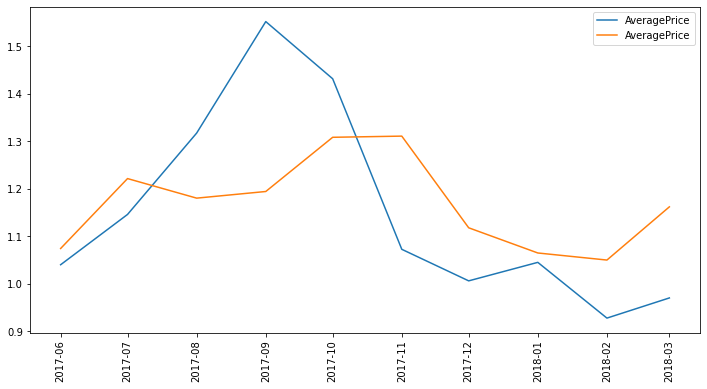

In [232]:
#Visualize thre result
plt.figure(figsize=(12,6))
plt.plot(y_test_value, label='AveragePrice')
plt.plot(y_pred_value, label='AveragePrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

<ipython-input-233-fc727835a72a>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


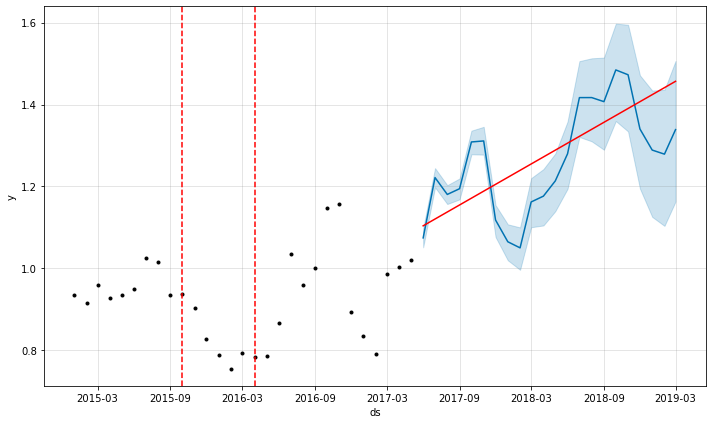

In [233]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), model, forecast)

<ipython-input-234-a8e790e14005>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


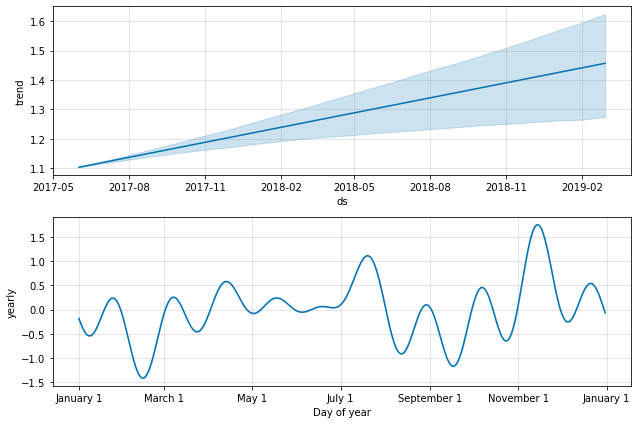

In [234]:
fig1 =model.plot_components(forecast)
fig1.show()

Prediction for next 12 months

In [235]:
forecast[['ds','yhat']].tail(12)

ds      yhat
10 2018-04-01  1.176249
11 2018-05-01  1.213399
12 2018-06-01  1.279635
13 2018-07-01  1.416955
14 2018-08-01  1.417031
15 2018-09-01  1.407076
16 2018-10-01  1.484576
17 2018-11-01  1.472754
18 2018-12-01  1.340343
19 2019-01-01  1.288784
20 2019-02-01  1.278813
21 2019-03-01  1.338755

Long-term prediction for the next 5 years ==> Consider whether to expand Cultivation/production, and trading

In [236]:
m = Prophet(yearly_seasonality=True, \
               daily_seasonality=False, weekly_seasonality=False)
m.fit(df_ts)
future = m.make_future_dataframe(periods=12*5, freq="M") # next 5 years

In [237]:
forecast = m.predict(future)

In [238]:
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper','trend', 'trend_lower', 'trend_upper' ]].tail(12)

ds      yhat  yhat_lower  yhat_upper     trend  trend_lower  \
87 2022-03-31  1.535200    1.318561    1.742993  1.667845     1.471605   
88 2022-04-30  1.617160    1.397866    1.851822  1.677947     1.475388   
89 2022-05-31  1.676734    1.451625    1.902586  1.688386     1.480175   
90 2022-06-30  1.783455    1.549883    2.016686  1.698488     1.485518   
91 2022-07-31  1.953500    1.721011    2.191048  1.708926     1.490733   
92 2022-08-31  1.836666    1.602989    2.087068  1.719365     1.494485   
93 2022-09-30  1.749073    1.509343    2.006517  1.729467     1.498849   
94 2022-10-31  1.690032    1.448922    1.944155  1.739905     1.504453   
95 2022-11-30  1.768684    1.503587    2.034080  1.750007     1.509640   
96 2022-12-31  1.740868    1.471921    2.013026  1.760446     1.510937   
97 2023-01-31  1.645610    1.366062    1.929057  1.770884     1.515062   
98 2023-02-28  1.556723    1.274314    1.839224  1.780313     1.518426   

    trend_upper  
87     1.850144  
88     1.866467  
89     1.883357  
90     1.899504  
91     1.914839  
92     1.931469  
93     1.944344  
94     1.961489  
95     1.976305  
96     1.994855  
97     2.012919  
98     2.027366

In [239]:
forecast.shape

(99, 16)

<ipython-input-240-dff77b8c9024>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


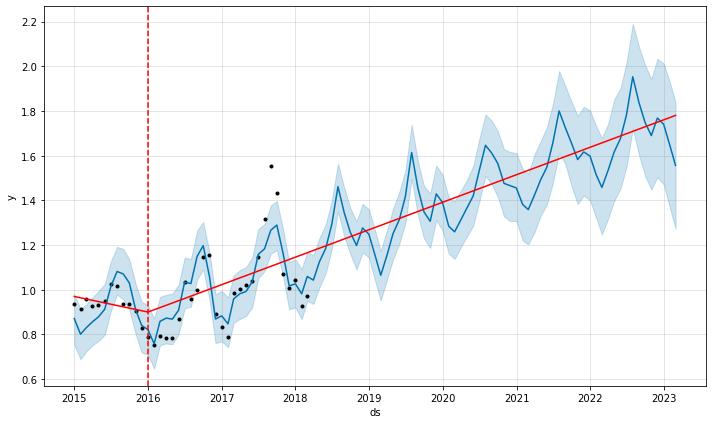

In [240]:
fig = m.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), m, forecast)

<ipython-input-241-b4b7495d9b67>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


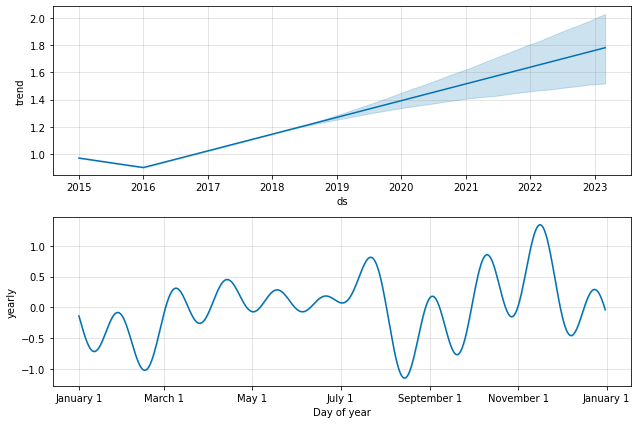

In [241]:
fig1 =m.plot_components(forecast)
fig1.show()

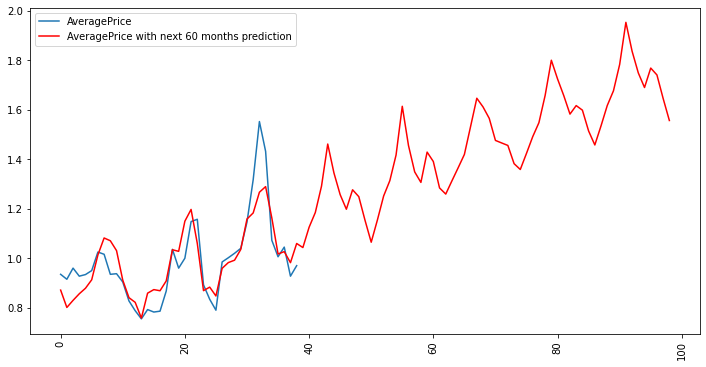

In [242]:
plt.figure(figsize=(12,6))
plt.plot(df_ts['y'], label='AveragePrice')
plt.plot(forecast['yhat'], label='AveragePrice with next 60 months prediction',
        color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

+ Base on the above results , we can see that it is possile to expand the cultivation/production and trading of organic avocados in West
+ Even conventional avocado is more potential because trend raise ratio (2017 -2023(predict)) of conventinal is higher than organic